In [1]:
# A LIMPIAR LIBRERIAS NO USADAS! 
# data
#from new_or_used import build_dataset
import json

#generales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

#tratamiento de datos faltantes e imputación
import missingno as msno
#from sklearn.impute import KNNImputer
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#selección de variables
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

#configuraciones generales
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
def build_raw_data():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    return data

In [3]:
data = build_raw_data()
df_full = pd.json_normalize(data)

In [4]:
#cantidad de elementos en el dataset
df_full.shape

(100000, 56)

# Análisis exploratorio

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   warranty                          39104 non-null   object 
 1   sub_status                        100000 non-null  object 
 2   condition                         100000 non-null  object 
 3   deal_ids                          100000 non-null  object 
 4   base_price                        100000 non-null  float64
 5   non_mercado_pago_payment_methods  100000 non-null  object 
 6   seller_id                         100000 non-null  int64  
 7   variations                        100000 non-null  object 
 8   site_id                           100000 non-null  object 
 9   listing_type_id                   100000 non-null  object 
 10  price                             100000 non-null  float64
 11  attributes                        100000 non-null  ob

In [6]:
df = df_full.dropna(axis=1, how='all')

In [7]:
VARIABLES_NUMERICAS = df.select_dtypes(include=['number']).columns.tolist()
VARIABLES_CATEGORICAS = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Total columnas: "+str(len(df_full.columns)))
print(str(len(VARIABLES_NUMERICAS))+"Numeric columns:", VARIABLES_NUMERICAS)
print(str(len(VARIABLES_CATEGORICAS))+" Categorical columns:", VARIABLES_CATEGORICAS)
print("Total non nulls columns: "+str(len(VARIABLES_NUMERICAS)+len(VARIABLES_CATEGORICAS)))
print("Deleted nulls columns: ",[x for x in df_full.columns if x not in VARIABLES_NUMERICAS+VARIABLES_CATEGORICAS])

Total columnas: 56
11Numeric columns: ['base_price', 'seller_id', 'price', 'official_store_id', 'original_price', 'stop_time', 'catalog_product_id', 'initial_quantity', 'start_time', 'sold_quantity', 'available_quantity']
43 Categorical columns: ['warranty', 'sub_status', 'condition', 'deal_ids', 'non_mercado_pago_payment_methods', 'variations', 'site_id', 'listing_type_id', 'attributes', 'buying_mode', 'tags', 'listing_source', 'parent_item_id', 'coverage_areas', 'category_id', 'descriptions', 'last_updated', 'international_delivery_mode', 'pictures', 'id', 'accepts_mercadopago', 'currency_id', 'thumbnail', 'title', 'automatic_relist', 'date_created', 'secure_thumbnail', 'status', 'video_id', 'permalink', 'seller_address.country.name', 'seller_address.country.id', 'seller_address.state.name', 'seller_address.state.id', 'seller_address.city.name', 'seller_address.city.id', 'shipping.local_pick_up', 'shipping.methods', 'shipping.tags', 'shipping.free_shipping', 'shipping.mode', 'shippin

En base a los datos presentados hasta ahora se pueden destacar los siguientes puntos:
* El dataset contiene 100 mil registros y 56 columnas.
* Hay dos columnas vacías que no aportan valor, fueron eliminadas.
* Hay varias columnas vacías que aportan poco valor, se va a analizar mas adelante.
* La mayoría de las columnas no tienen datos faltantes. 
* Varias columnas poseen campos de tipo dict, el cual puede llegar a aportar mayor valor al descomponerse.


## Identificación de tipos de datos

Para comenzar con el análisis exploratorio de los datos, se procede a identificar los tipos de datos de cada columna. Clasificando las columnas en datos cualitativos y cuantitativos, con sus respectivas subcategorías.

| Variable                            | Tipo de dato  | Subcategoría | Escala de medida |
|-------------------------------------|---------------|--------------|------------------|
| base_price                          | Cuantitativa  | Continua     | de razón         |
| seller_id                           | Cualitativa   | -            | Nominal          |
| price                               | Cuantitativa  | Continua     | de razón         |
| official_store_id                   | Cualitativa   | -            | Nominal          |
| original_price                      | Cuantitativa  | Continua     | de razón         |
| stop_time                           | Cualitativa   | -            | Ordinal          |
| catalog_product_id                  | Cualitativa   | -            | Nominal          |
| initial_quantity                    | Cuantitativa  | Discreta     | de razón         |
| start_time                          | Cualitativa   | -            | Ordinal          |
| sold_quantity                       | Cuantitativa  | Discreta     | de razón         |
| available_quantity                  | Cuantitativa  | Discreta     | de razón         |
| seller_address                      | Cualitativa   | -            | Nominal          |
| warranty                            | Cualitativa   | -            | Nominal          |
| sub_status                          | Cualitativa   | -            | Nominal          |
| condition                           | Cualitativa   | -            | Nominal          |
| deal_ids                            | Cualitativa   | -            | Nominal          |
| shipping                            | Cualitativa   | -            | Nominal          |
| non_mercado_pago_payment_methods    | Cualitativa   | -            | Nominal          |
| variations                          | Cualitativa   | -            | Nominal          |
| site_id                             | Cualitativa   | -            | Nominal          |
| listing_type_id                     | Cualitativa   | -            | Nominal          |
| attributes                          | Cualitativa   | -            | Nominal          |
| buying_mode                         | Cualitativa   | -            | Nominal          |
| tags                                | Cualitativa   | -            | Nominal          |
| listing_source                      | Cualitativa   | -            | Nominal          |
| parent_item_id                      | Cualitativa   | -            | Nominal          |
| coverage_areas                      | Cualitativa   | -            | Nominal          |
| category_id                         | Cualitativa   | -            | Nominal          |
| descriptions                        | Cualitativa   | -            | Nominal          |
| last_updated                        | Cualitativa   | -            | Ordinal          |
| international_delivery_mode         | Cualitativa   | -            | Nominal          |
| pictures                            | Cualitativa   | -            | Nominal          |
| id                                  | Cualitativa   | -            | Nominal          |
| accepts_mercadopago                 | Cualitativa   | -            | Nominal          |
| currency_id                         | Cualitativa   | -            | Nominal          |
| thumbnail                           | Cualitativa   | -            | Nominal          |
| title                               | Cualitativa   | -            | Nominal          |
| automatic_relist                    | Cualitativa   | -            | Nominal          |
| date_created                        | Cualitativa   | -            | Ordinal          |
| secure_thumbnail                    | Cualitativa   | -            | Nominal          |
| status                              | Cualitativa   | -            | Nominal          |
| video_id                            | Cualitativa   | -            | Nominal          |
| permalink                           | Cualitativa   | -            | Nominal          |

## Identificación de variables de entrada y salida.

### Variable de salida: condition

In [8]:
VARIABLE_SALIDA = 'condition'
df[VARIABLE_SALIDA].unique()

array(['new', 'used'], dtype=object)

Esta columna contiene dos valores posibles: "new" y "used". Se puede observar que la variable de salida es binaria por lo que se puede considerar un problema de clasificación binaria. Por lo tanto, se considera favorable convertir la variable de salida a valores numéricos, asignando 1 a "used" y 0 a "new".

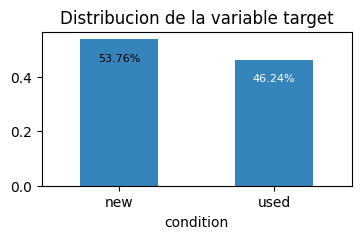

In [9]:
fig = plt.figure(figsize=(4, 2))
ax = df[VARIABLE_SALIDA].value_counts(normalize=True).plot(kind='bar', alpha=0.9, rot=0)

for idx, p in enumerate(ax.patches):
    color = 'black' if idx == 0 else 'white'
    ax.annotate(f'{p.get_height():.2%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='top',
                xytext=(0, -10), # ajusto la etiqueta
                textcoords='offset points',
                fontsize=8,
                color=color)
plt.title('Distribucion de la variable target')
plt.show()

Como se puede observar, la variable de salida presenta un buen balance en los datos. Esto puede ser beneficioso en el rendimiento de los modelos de clasificación.

### Variables de entrada

In [10]:
# visualización de datos númericos
df[VARIABLES_NUMERICAS].head(4)

,base_price,seller_id,price,official_store_id,original_price,stop_time,catalog_product_id,initial_quantity,start_time,sold_quantity,available_quantity
0,80.0,8208882349,80.0,NaN,NaN,1446669773000,NaN,1,1441485773000,0,1
1,2650.0,8141699488,2650.0,NaN,NaN,1448474910000,NaN,1,1443290910000,0,1
2,60.0,8386096505,60.0,NaN,NaN,1447027027000,NaN,1,1441843027000,0,1
3,580.0,5377752182,580.0,NaN,NaN,1449191596000,NaN,1,1443466076000,0,1


In [11]:
# visualización de datos categóricos
if VARIABLE_SALIDA in VARIABLES_CATEGORICAS:
    VARIABLES_CATEGORICAS.remove("condition")
df[VARIABLES_CATEGORICAS].head(4)

,warranty,sub_status,deal_ids,non_mercado_pago_payment_methods,variations,site_id,listing_type_id,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,accepts_mercadopago,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,status,video_id,permalink,seller_address.country.name,seller_address.country.id,seller_address.state.name,seller_address.state.id,seller_address.city.name,seller_address.city.id,shipping.local_pick_up,shipping.methods,shipping.tags,shipping.free_shipping,shipping.mode,shipping.dimensions,shipping.free_methods
0,None,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],MLA,bronze,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA4695330653,True,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,active,None,http://articulo.mercadolibre.com.ar/MLA4695330...,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,True,[],[],False,not_specified,None,NaN
1,NUESTRA REPUTACION,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],MLA,silver,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA7160447179,True,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,active,None,http://articulo.mercadolibre.com.ar/MLA7160447...,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,True,[],[],False,me2,None,NaN
2,None,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],MLA,bronze,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7367189936,True,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,active,None,http://articulo.mercadolibre.com.ar/MLA7367189...,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,True,[],[],False,me2,None,NaN
3,None,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],MLA,silver,[],buy_it_now,[],,None,[],MLA86345,[{'id': 'MLA9191625553-932309698'}],2015-10-05T16:03:50.306Z,none,"[{'size': '441x423', 'secure_url': 'https://a2...",MLA9191625553,True,ARS,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28T18:47:56.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,active,None,http://articulo.mercadolibre.com.ar/MLA9191625...,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,True,[],[],False,me2,None,NaN


Vemos que no todas las columnas aportan información útil para el entrenamiento de un modelo. Por ende se van a eliminar las que resultan redundantes como variables de entrada. Es un proceso manual pero relativamente rápido, donde se verifica el contenido de una columna y sus valores únicos. 
No se va a dejar todo el código de pruebas por prolijidad. Las conclusiones sobre los campos a modificar son:

- **warranty**  # Armar flag de detección de: `SI`, número, `Usado`, `garantía`.
- **non_mercado_pago_payment_methods**  # [{'description': 'Transferencia bancaria', 'id': 'MLATB', 'type': 'G'}, {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}]
- **variations**  # [{'attribute_combinations': [{'value_id': '92'}]}]
- **attributes**  # [{'value_id': 'male', 'attribute_group_id': 'group_1'}]
- **last_updated**  # To cast.
- **pictures**  # To delete. Armar un `count`.
- **title**  # Armar flag si dice `usado`.
- **date_created**  # To cast.
- **seller_address.country.name**  # To delete, no value. All Arg
- **seller_address.country.id**  # To delete.
- **seller_address.state.name**  # To delete, correlated to `state.id` 100%. Create an `id_to_name` list.
- **seller_address.city.name**  # Keep it because `city.id` has many nulls.
- **shipping.methods**  # To delete, `99931` almost null.
- **shipping.tags**  # To delete, `99931` almost null.
- **shipping.free_methods**  # [{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73328}]

In [12]:
# Eliminacion campos redundantes
# usando df["field name"].value_counts().head(5) vemos que los campos redundantes son:
variables_to_drop = ["listing_source","parent_item_id","coverage_areas","site_id","descriptions","international_delivery_mode",
                     "id","thumbnail","secure_thumbnail","permalink", "seller_address.country.name", "seller_address.country.id", 
                     "seller_address.state.name", "shipping.methods", "shipping.tags"]

for variable in variables_to_drop:
    VARIABLES_CATEGORICAS.remove(variable)
    df.drop(variable, axis=1, inplace=True)
if VARIABLE_SALIDA in VARIABLES_CATEGORICAS:
    VARIABLES_CATEGORICAS.remove(VARIABLE_SALIDA)
        

Las variables de entrada que contienen listas de diccionarios van a ser expandidas:
- non_mercado_pago_payment_methods
- variations
- attributes
- shipping.free_methods

#### Expansion de campos

In [13]:
def explode_field(df, field, key):
    name = f'{field}.{key}'
    exploded_df = df.explode(field)
    new_column = exploded_df[field].apply(lambda x: x[key] if isinstance(x, dict) else None)
    new_column.name = name
    return new_column

##### non_mercado_pago_payment_methods

In [14]:
# Armo series de valores por row

method_id = explode_field(df, 'non_mercado_pago_payment_methods', 'id')
#method_description = explode_field(df, 'non_mercado_pago_payment_methods', 'description') # no aporta info extra
method_type = explode_field(df, 'non_mercado_pago_payment_methods', 'type')

df.drop(columns=['non_mercado_pago_payment_methods'], inplace=True)
method_ids = method_id.dropna().reset_index()
payment_methods = pd.concat([method_id, method_type], axis=1)

payment_methods.dropna().reset_index().to_csv("dataset/extra/payment_methods.csv", index=False)

##### variations

In [15]:
variations_attribute_combinations = explode_field(df, 'variations', 'attribute_combinations').apply(lambda x: len(x) if isinstance(x, list) else 0) #uso len porque el campo no me aporta valor si no
#variations_seller_custom_field = explode_field(df, 'variations', 'seller_custom_field') # no aporta info
#variations_id = explode_field(df, 'variations', 'id') # no aporta info
variations_picture_ids = explode_field(df, 'variations', 'picture_ids').apply(lambda x: len(x) if isinstance(x, list) else 0) #uso len porque el campo no me aporta valor si no
variations_sold_quantity = explode_field(df, 'variations', 'sold_quantity')
variations_available_quantity = explode_field(df, 'variations', 'available_quantity')
variations_price = explode_field(df, 'variations', 'price')
variations = pd.concat([variations_attribute_combinations, variations_picture_ids, variations_sold_quantity, variations_available_quantity, variations_price], axis=1)

df.drop(columns=['variations'], inplace=True)
variations_attribute_combinations = variations.dropna().reset_index()
variations.dropna().reset_index().to_csv("dataset/extra/variations.csv", index=False)


##### attributes

In [16]:
df['attributes'] = df['attributes'].apply(lambda x: len(x) if isinstance(x, list) else None)

##### shipping.free_methods

In [17]:
shipping_free_methods_id = explode_field(df, 'shipping.free_methods', 'id') 

df.drop(columns=['shipping.free_methods'], inplace=True)
shipping_free_methods_id = shipping_free_methods_id.dropna().reset_index()
shipping_free_methods_id.dropna().reset_index().to_csv("dataset/extra/shipping_free_methods.csv", index=False)


In [18]:
for field in ['non_mercado_pago_payment_methods', 'variations', 'shipping.free_methods']:
    VARIABLES_CATEGORICAS.remove(field)

####  Variables de entrada Númericas

A continuación se muestra un resumen de las distribuciones y los boxplot de las variables númericas, para posteriormente empezar el análisis de cada una de ellas.

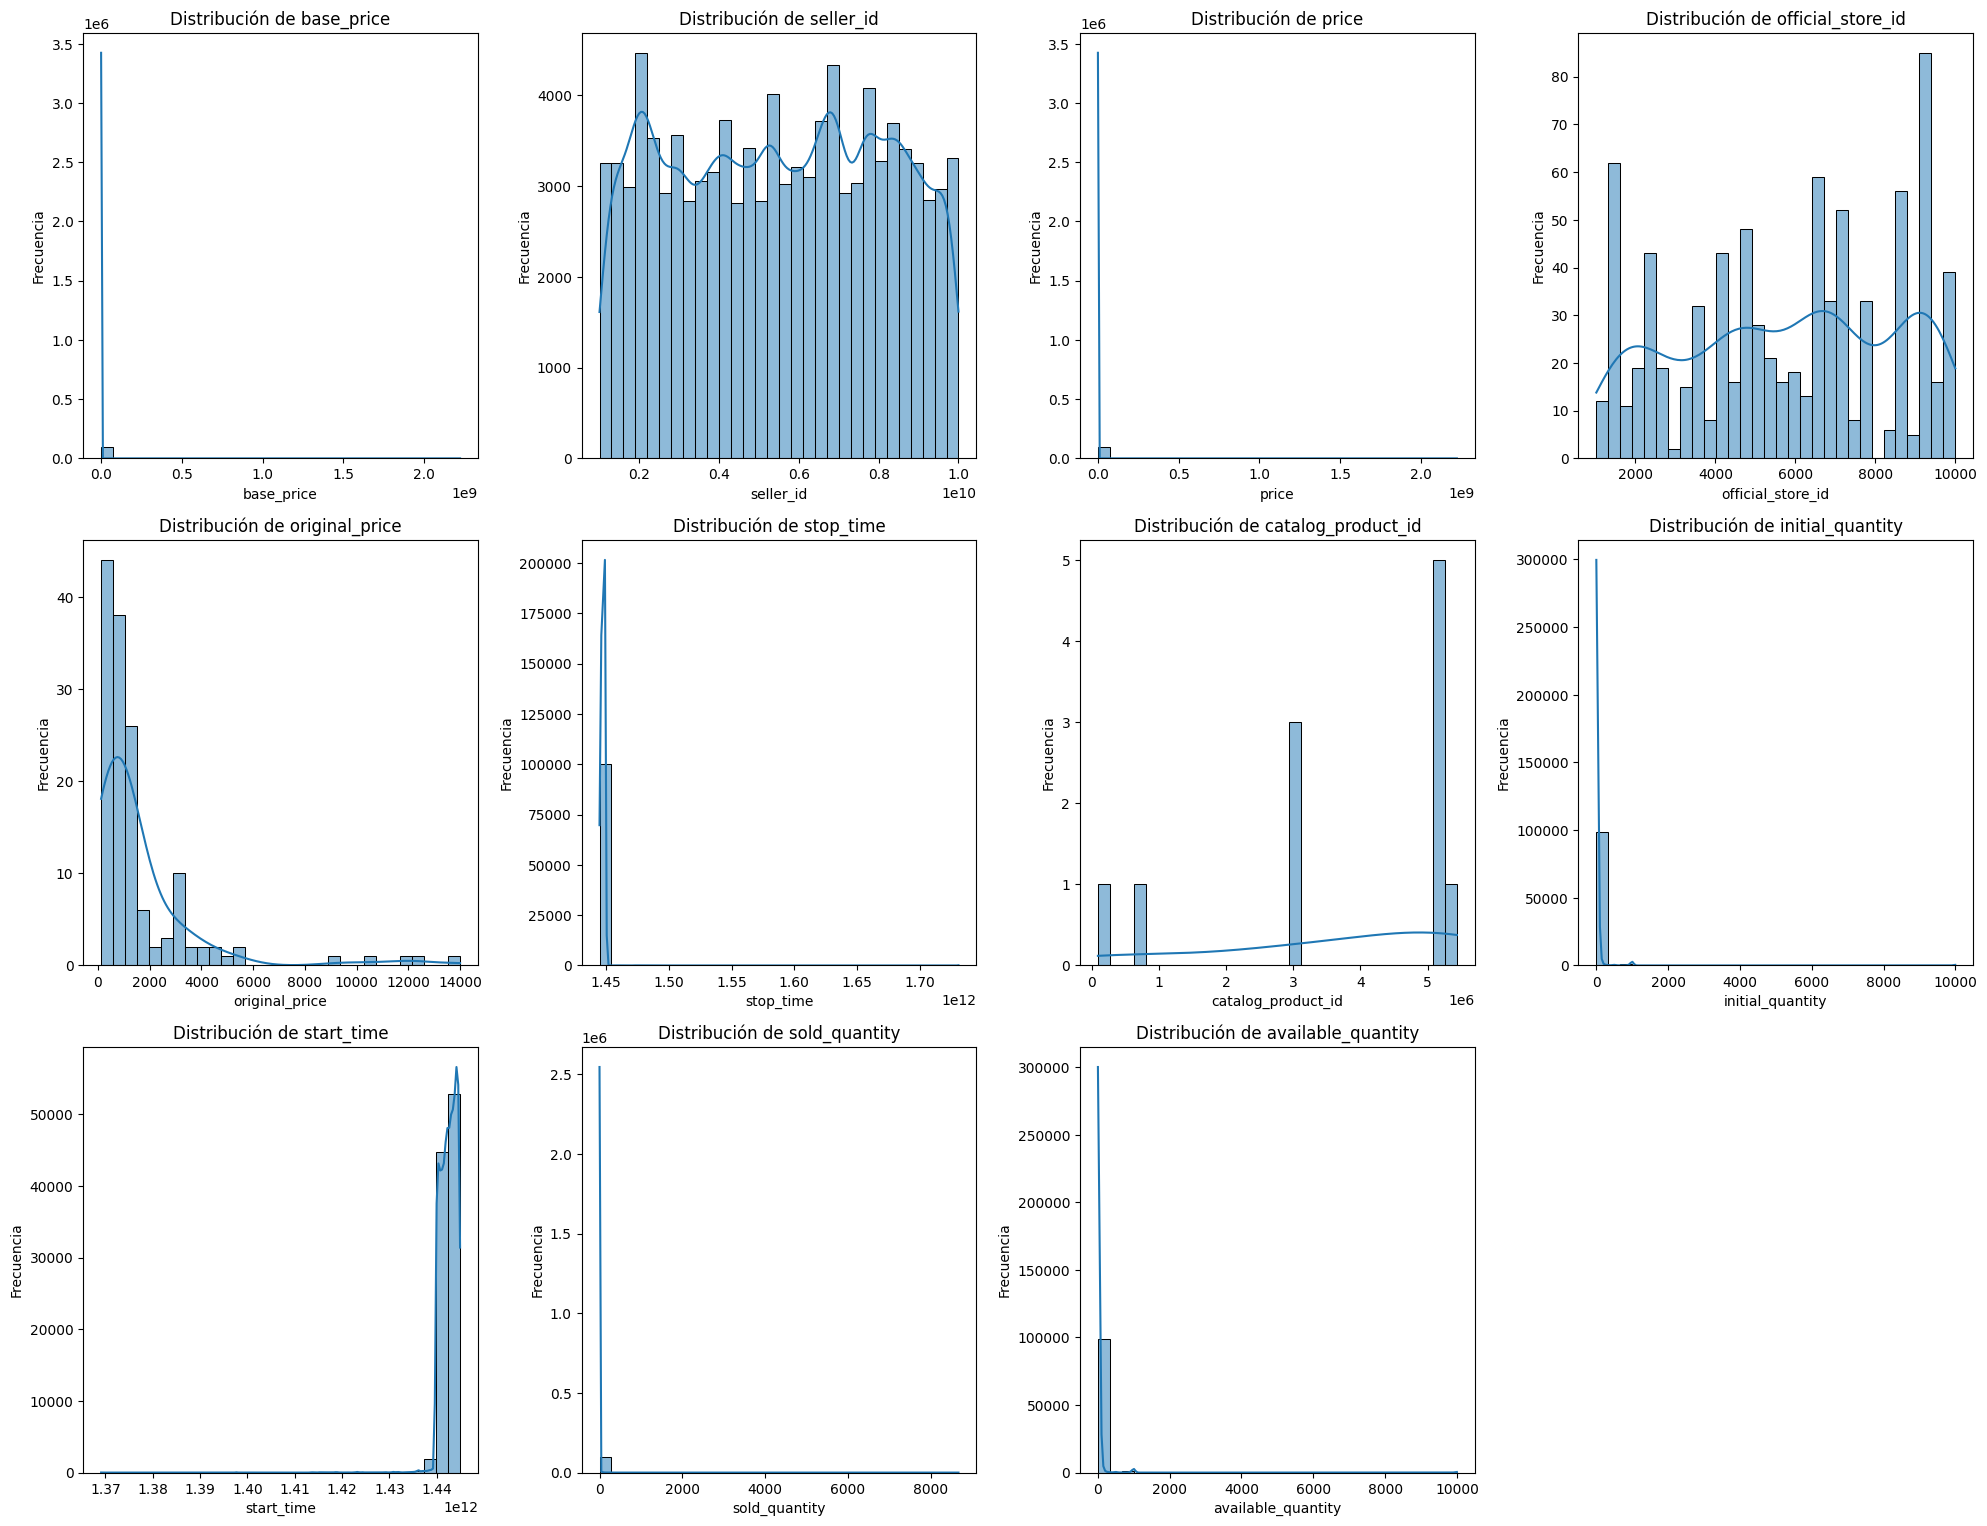

In [19]:
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, col in enumerate(VARIABLES_NUMERICAS):
    row = i // ncols
    col_idx = i % ncols
    sns.histplot(df[col], kde=True, bins=30, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribución de {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frecuencia')

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

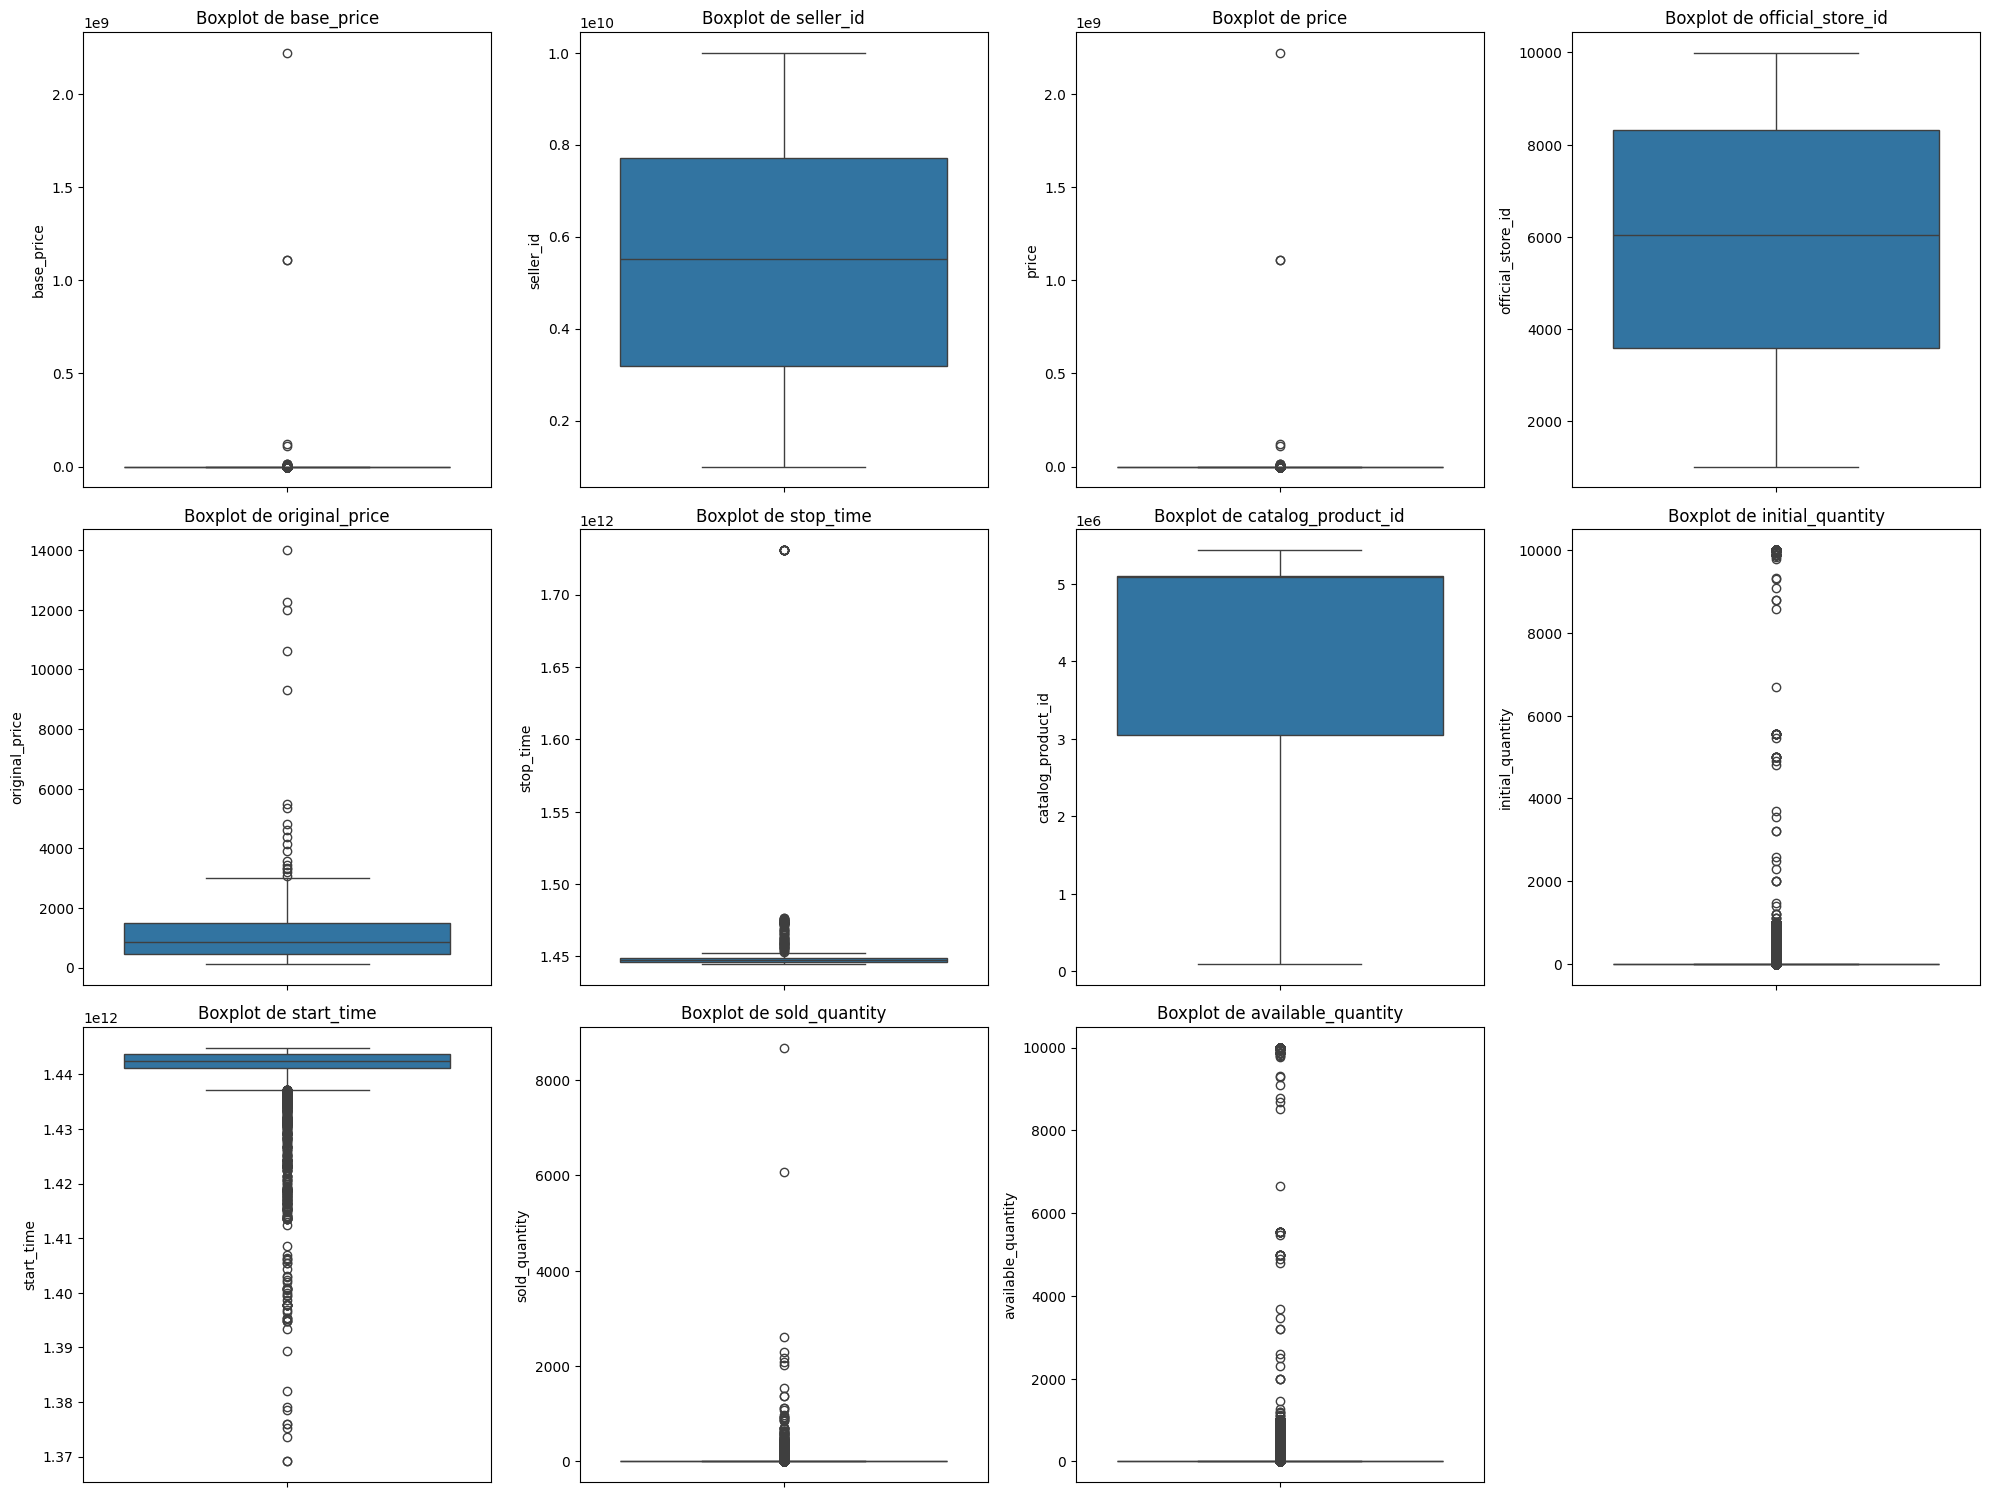

In [20]:
#boxplot de las variables numéricas
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, col in enumerate(VARIABLES_NUMERICAS):
    row = i // ncols
    col_idx = i % ncols
    sns.boxplot(y=col, data=df, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')
    axes[row, col_idx].set_ylabel(col)

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()




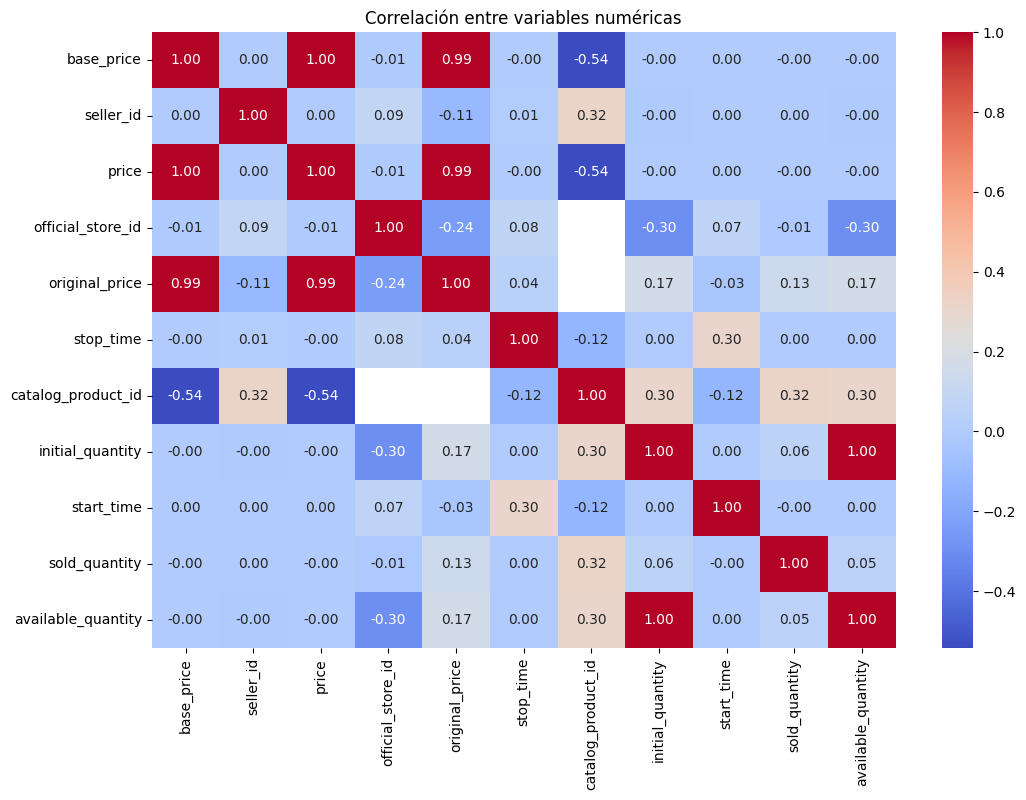

In [21]:
# correlación seaborn entre variables numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(df[VARIABLES_NUMERICAS].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre variables numéricas')
plt.show()

En un primer momento se observan diferentes formas de distribuciónes que se van a tener que ir analizando, así como también la presencia de outliers en algunas variables que pueden ser problemáticos para el análisis.
Además se pueden observer una alta correlación entre las variables de precio, lo cual es esperado.

##### Variables de precio

In [22]:
PRICE_VARS = ['original_price', 'base_price', 'price']
df[PRICE_VARS].describe()

,original_price,base_price,price
count,143.000000,1.000000e+05,1.000000e+05
mean,1593.341958,5.252423e+04,5.252433e+04
std,2245.798072,8.623127e+06,8.623127e+06
min,120.000000,8.400000e-01,8.400000e-01
25%,449.000000,9.000000e+01,9.000000e+01
50%,858.000000,2.500000e+02,2.500000e+02
75%,1500.000000,8.000000e+02,8.000000e+02
max,13999.000000,2.222222e+09,2.222222e+09


Se eliminan las variables 'base_price', 'original_price' por su alta correlacion con 'price'. No se observan valores de 'price' negativos o nulos. 'original_price' posee gran cantidad de datos nulos.

In [23]:
VARIABLES_NUMERICAS.remove('base_price')
df.drop(columns=['base_price'], inplace=True)
VARIABLES_NUMERICAS.remove('original_price')
df.drop(columns=['original_price'], inplace=True)

Se aprecia las 9 variables se comportan de manera bastante similar, en la gran mayoria categóricas. Con distribuciones que a simple vista no parecen aproximarse a la Normal. A continuación se analizarán gráficos QQ para visualizar mejor este ajuste en las variables cuantitativas continuas y discretas: original_price , initial_quantity, sold_quantity, available_quantity.

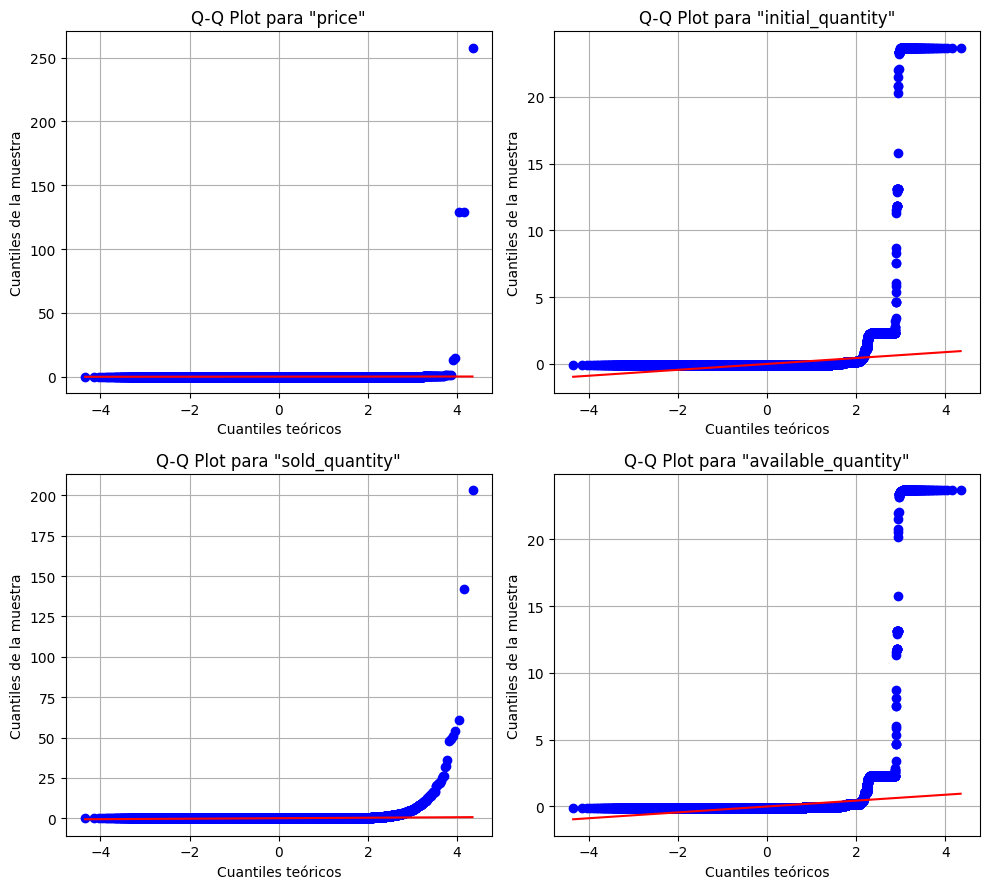

In [24]:
# Calcular datos estandarizados
temp_vars = ["price" , "initial_quantity", "sold_quantity", "available_quantity"]
temp_vars_standarized = (df[temp_vars] - df[temp_vars].mean()) / df[temp_vars].std()

# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

# Iterar sobre las variables de temperatura y graficar el Q-Q plot en cada subgráfico
for i, var in enumerate(temp_vars):
    ax = axes[i//2, i%2]
    stats.probplot(temp_vars_standarized[var], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot para "{var}"')
    ax.set_xlabel('Cuantiles teóricos')
    ax.set_ylabel('Cuantiles de la muestra')
    ax.grid(True)
    #ax.plot([-3, 3], [-3, 3], ls="--", c=".3")  # Agregar línea de referencia

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Observando los Q-Q plots se puede observar que para las cuatro variables su distribución no se asemeja a una Normal. Si bien los puntos se alinean en los valores intermedios, los cuatro casos presentan colas algo livianas y puntas muy pronunciadas. 
Ninguna de las variables muestra un comportamiento normal en su totalidad. Los datos probablemente estén influenciados por sesgos, valores extremos o colas largas.

Es importante tenerlo en cuenta si se va a aplicar modelos que asumen normalidad.

##### Variables de time

In [25]:
df['stop_time']

0        1446669773000
1        1448474910000
2        1447027027000
3        1449191596000
4        1445638040000
             ...      
99995    1448586289000
99996    1447178942000
99997    1446762578000
99998    1445102548000
99999    1448024536000
Name: stop_time, Length: 100000, dtype: int64

In [26]:
TIME_VARS = ['start_time', 'stop_time']
df[TIME_VARS].describe()

,start_time,stop_time
count,1.000000e+05,1.000000e+05
mean,1.442383e+12,1.447646e+12
std,2.114372e+09,3.248586e+09
min,1.369110e+12,1.444823e+12
25%,1.441141e+12,1.446312e+12
50%,1.442522e+12,1.447640e+12
75%,1.443800e+12,1.448931e+12
max,1.444900e+12,1.730732e+12


In [27]:
pd.to_datetime(df['start_time'], unit='ms').describe()


count                           100000
mean     2015-09-16 05:48:30.129960192
min                2013-05-21 04:22:35
25%                2015-09-01 21:04:33
50%                2015-09-17 20:35:36
75%      2015-10-02 15:34:33.750000128
max                2015-10-15 09:14:30
Name: start_time, dtype: object

In [28]:
pd.to_datetime(df['stop_time'], unit='ms').describe()

count                           100000
mean     2015-11-16 03:53:10.695500032
min                2015-10-14 11:51:37
25%                2015-10-31 17:11:45
50%         2015-11-16 02:12:30.500000
75%      2015-12-01 00:45:32.249999872
max                2024-11-04 14:55:51
Name: stop_time, dtype: object

Los rangos de las variables de tiempo son coherentes.

##### Variables de IDs

In [29]:
ID_VARS = ['seller_id', 'official_store_id', 'catalog_product_id']
df[ID_VARS].describe()

,seller_id,official_store_id,catalog_product_id
count,1.000000e+05,818.000000,1.100000e+01
mean,5.490549e+09,5788.377751,3.727643e+06
std,2.587890e+09,2659.683382,1.884698e+06
min,1.000079e+09,1024.000000,9.440400e+04
25%,3.187707e+09,3590.000000,3.050702e+06
50%,5.522496e+09,6043.000000,5.093232e+06
75%,7.704930e+09,8320.000000,5.103216e+06
max,9.999853e+09,9996.000000,5.434513e+06


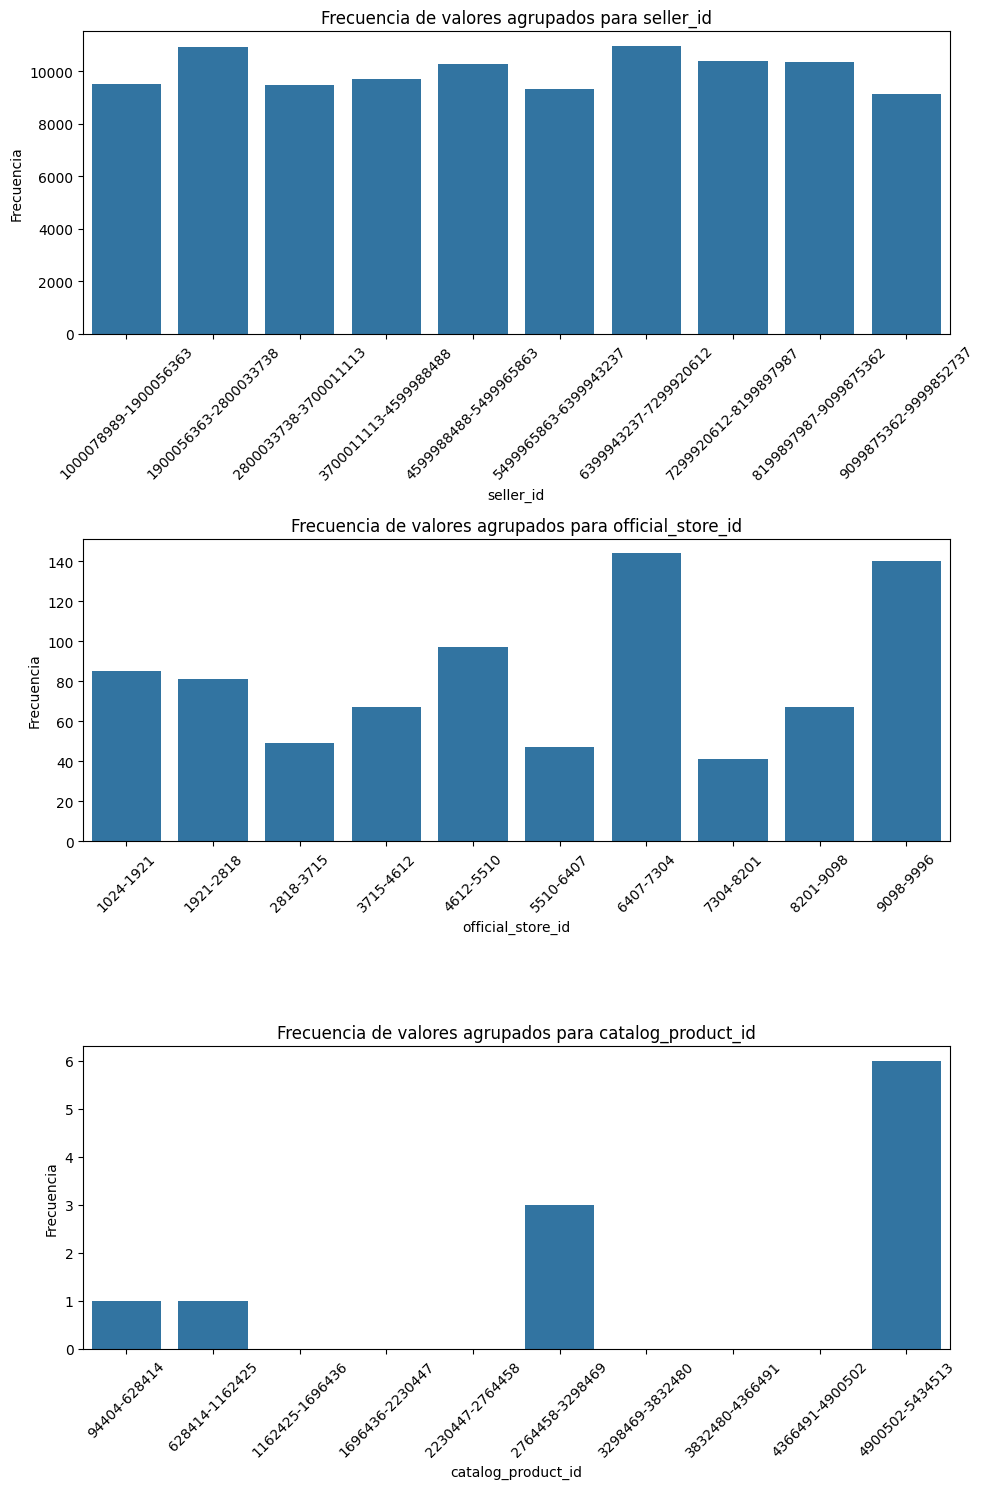

In [30]:
# Crear bins para las variables de ID
BIN_COUNT = 10  # Número de bins que deseas crear

# Crear un DataFrame para almacenar las variables binned
df_binned = df.copy()

for var in ID_VARS:
    min_val = df[var].min()
    max_val = df[var].max()
    # Crear bins y asignar etiquetas
    bins = np.linspace(min_val, max_val, BIN_COUNT + 1)
    labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    df_binned[var] = pd.cut(df[var], bins=bins, labels=labels, include_lowest=True)

# Graficar las frecuencias de los bins
fig, axes = plt.subplots(len(ID_VARS), 1, figsize=(10, 5 * len(ID_VARS)))

for i, var in enumerate(ID_VARS):
    ax = axes[i]
    sns.countplot(data=df_binned, x=var, ax=ax) #, order=df_binned[var].value_counts().index)
    ax.set_title(f'Frecuencia de valores agrupados para {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x si son largas

plt.tight_layout()
plt.show()

El campo seller_id se asemeja más a una distribución uniforme en comparación a los campos catalog_product_id y oficial_store_id. Mientras más uniforme es una distribución, menos información útil va a aportar para una desición en el modelado.

In [31]:
sellers_id = list(df['seller_id'].value_counts().head(2000).index)

In [32]:
df['seller_id'] = np.where(df['seller_id'].isin(sellers_id), df['seller_id'], 0)

#### Variables de entrada Categóricas

In [33]:
df[VARIABLES_CATEGORICAS].columns

Index(['warranty', 'sub_status', 'deal_ids', 'listing_type_id', 'attributes',
       'buying_mode', 'tags', 'category_id', 'last_updated', 'pictures',
       'accepts_mercadopago', 'currency_id', 'title', 'automatic_relist',
       'date_created', 'status', 'video_id', 'seller_address.state.id',
       'seller_address.city.name', 'seller_address.city.id',
       'shipping.local_pick_up', 'shipping.free_shipping', 'shipping.mode',
       'shipping.dimensions'],
      dtype='object')

Las variables categóricas que se analizarán son las siguientes, agrupandolas en dos categorías para facilitar su análisis:
* **Variables de ids** 
* **Variables de fecha**
* **Variables otras**

##### Variables de IDs

In [34]:
# Obtener las columnas que contienen la palabra 'id'
ID_VARS = [col for col in df[VARIABLES_CATEGORICAS].columns if 'id' in col.lower()]
ID_VARS

['deal_ids',
 'listing_type_id',
 'category_id',
 'currency_id',
 'video_id',
 'seller_address.state.id',
 'seller_address.city.id']

In [35]:
print(df['deal_ids'].value_counts())
df.drop(columns=['deal_ids'], inplace=True)
ID_VARS.remove('deal_ids')

deal_ids
[]         99760
[MOSH6]       60
[WGPLA]       41
[15H9O]       28
[ABQ1I]       28
[LZFND]       22
[JXLIQ]        7
[MISCR]        6
[CHMGI]        6
[R99GD]        5
[GAC6A]        5
[GRMWV]        3
[AZEBL]        3
[UQU1U]        3
[ZZMKC]        2
[BBLRY]        2
[UKXWI]        2
[UUINF]        2
[VYYJI]        2
[PPW2S]        1
[YOLH8]        1
[7FOQD]        1
[WO4YE]        1
[Y3MPW]        1
[805OS]        1
[ZZHBN]        1
[QXDHA]        1
[SI7I0]        1
[W40QU]        1
[F9G6U]        1
[CULNX]        1
[VR2RD]        1
Name: count, dtype: int64


In [36]:
for var in ID_VARS:
    # Verificar si la columna contiene listas
    if df[var].apply(lambda x: isinstance(x, list)).any():
        # Convertir listas a tuplas
        #unique_count = df[var].apply(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
        unique_count = df[var].apply(lambda x: x[0] if isinstance(x, list) else x).nunique()
    else:
        unique_count = df[var].nunique()
    
    print(f'Valores únicos para {var}: {unique_count}')

Valores únicos para listing_type_id: 7
Valores únicos para category_id: 10907
Valores únicos para currency_id: 2
Valores únicos para video_id: 2077
Valores únicos para seller_address.state.id: 25
Valores únicos para seller_address.city.id: 295


Para codificar este tipo de variables se pueden utilizar diferentes métodos. 
Uno de los más comunes es el de One-Hot Encoding. Si hubiese una alta cardinalidad u ordinalidad en las variables, se debería tener en cuenta otro tipo de codificación. 
En este caso, las variables tienen muchos valores unicos, sobre todo category id o city id implican un gran costo al realizar un one hot encoding por la cantidad de columnas que generan.
Por ende, vamos a recurrir a un labelEncoder.

Se va a graficar la distribucion sobre las clases para ver si se puede obviar algunas.

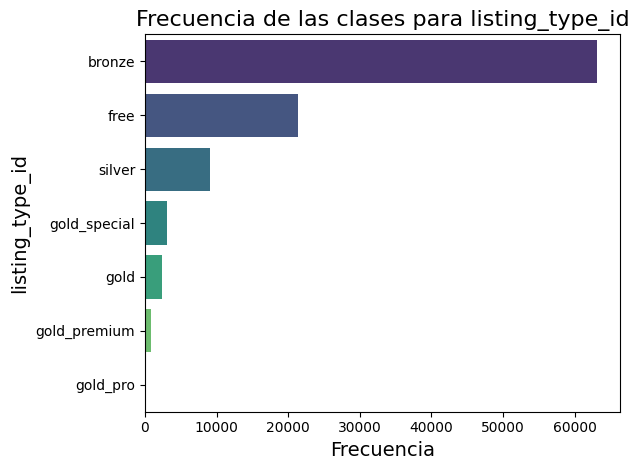

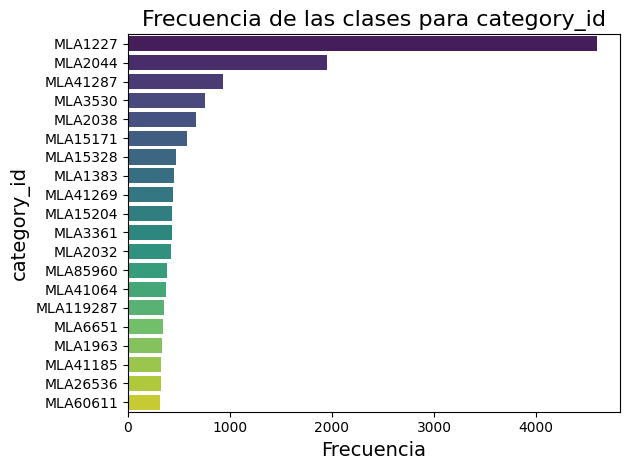

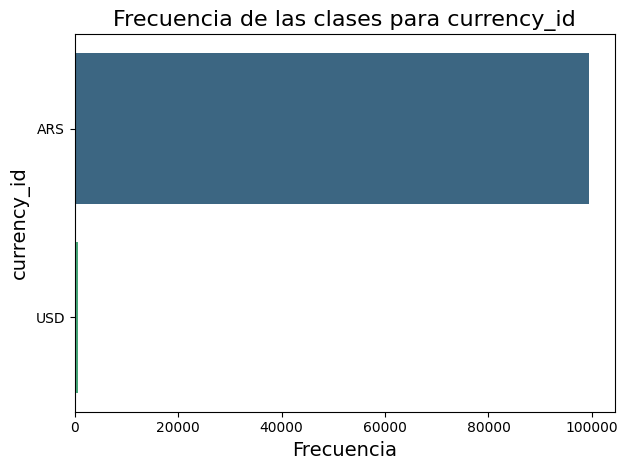

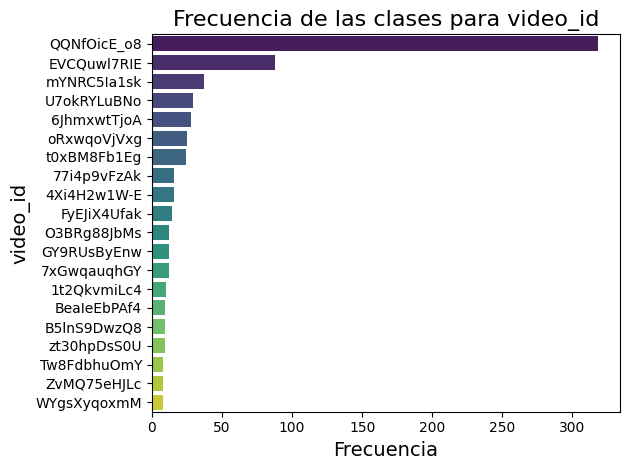

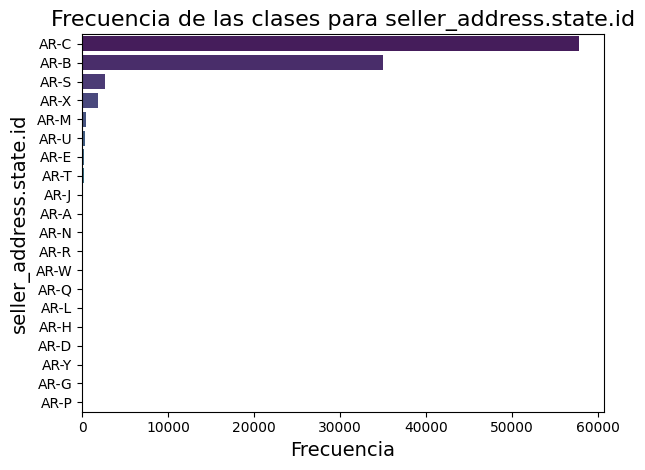

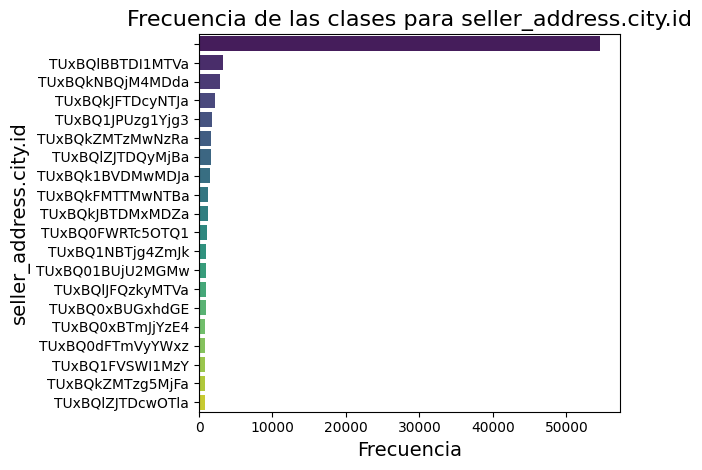

In [37]:
for var in ID_VARS:
    # Convertir listas a tuplas para evitar TypeError
    df[var] = df[var].apply(lambda x: x[0] if isinstance(x, list) else x)
    # Contar las frecuencias
    value_counts = df[var].value_counts().head(20)  # Mostrar solo las 20 clases más frecuentes
    sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")
    plt.title(f'Frecuencia de las clases para {var}', fontsize=16)
    plt.xlabel('Frecuencia', fontsize=14)
    plt.ylabel(var, fontsize=14)
    plt.tight_layout()
    plt.show()


- Se realizara one hot encoding en los features con pocas clases y label encoding en los demas.

In [38]:
df['category_id'] = df['category_id'].str[3:].astype(int)
categories_id = list(df['category_id'].value_counts().head(2000).index)
df['category_id'] = np.where(df['category_id'].isin(categories_id), df['category_id'], 0)

In [39]:
video_id = list(df['video_id'].value_counts().head(25).index)
df['video_id'] = df['video_id'].apply(lambda x: x if x in video_id else 'other')

In [40]:
one_hot_features  = ['listing_type_id', 'currency_id']
label_features = ['video_id', 'seller_address.state.id', 'seller_address.city.id']

##### Variables de fecha

In [41]:
df[['last_updated', 'date_created']] =  df[['last_updated', 'date_created']].apply(lambda col: pd.to_datetime(col).dt.date)

<Axes: >

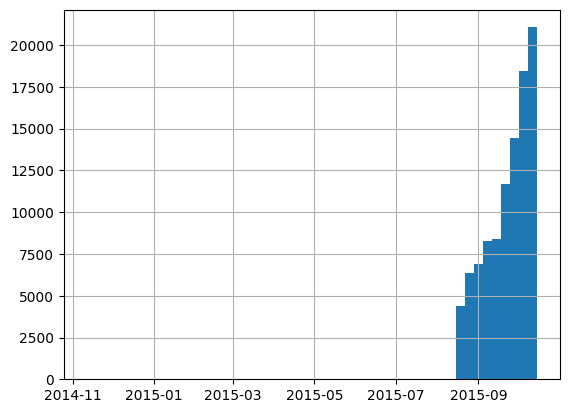

In [42]:
# Se genera un histograma para chequear la distribucion de las fechas en el rango de observaciones
df['last_updated'].hist(bins=50)

- Se va a analizar la estacionalidad mediante la distribucion por dia de semana y por mes.

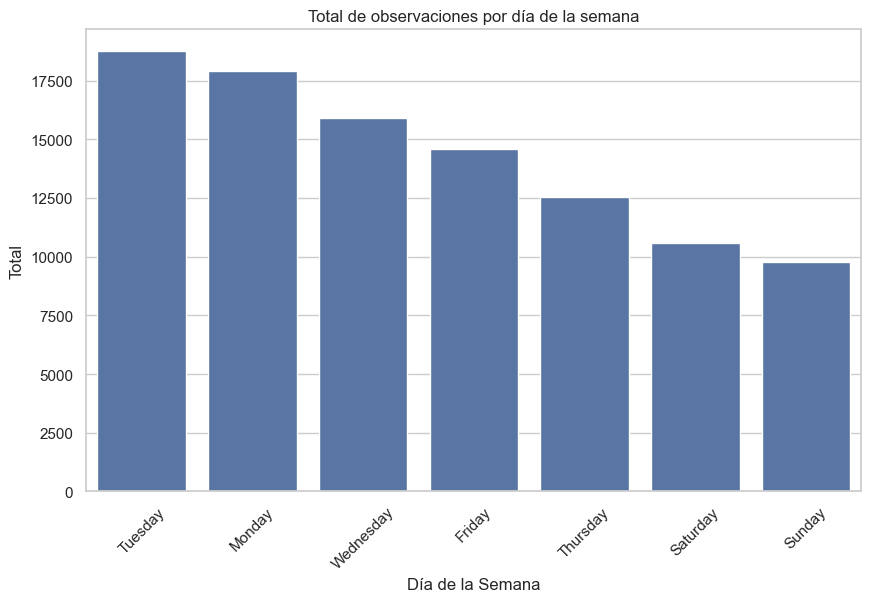

In [43]:
# Se grafica cómo se distribuyen las fechas en los días de la semana, para determinar si hay algún día en que no se registran.

week_day = df['date_created'].apply(pd.to_datetime).dt.day_name()


day_counts = week_day.value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values)

plt.title('Total de observaciones por día de la semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Total')
plt.xticks(rotation=45)

plt.show()

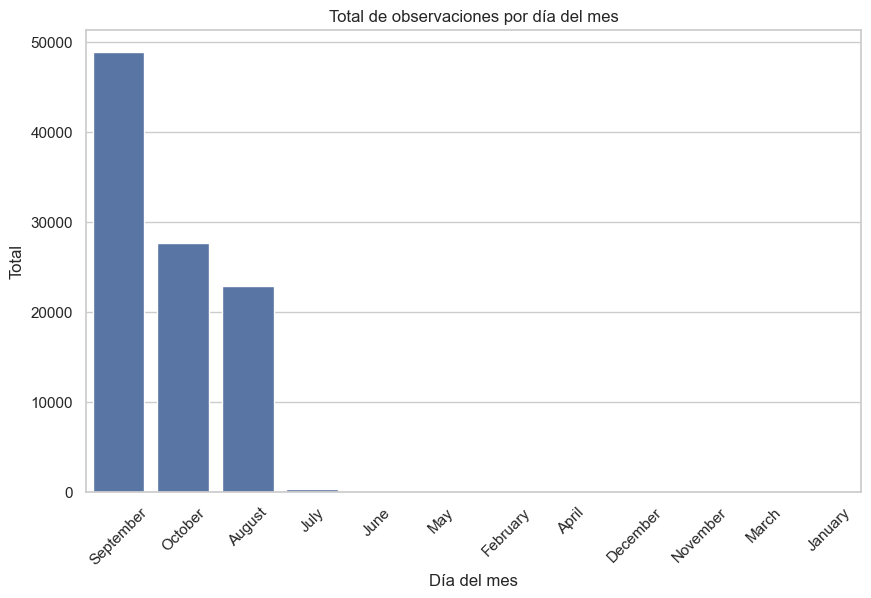

In [44]:
# Se grafica cómo se distribuyen las fechas en los meses del año, para determinar si hay algún patron o mes en que no se registran.

week_day = df['date_created'].apply(pd.to_datetime).dt.month_name()


day_counts = week_day.value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values)

plt.title('Total de observaciones por día del mes')
plt.xlabel('Día del mes')
plt.ylabel('Total')
plt.xticks(rotation=45)

plt.show()

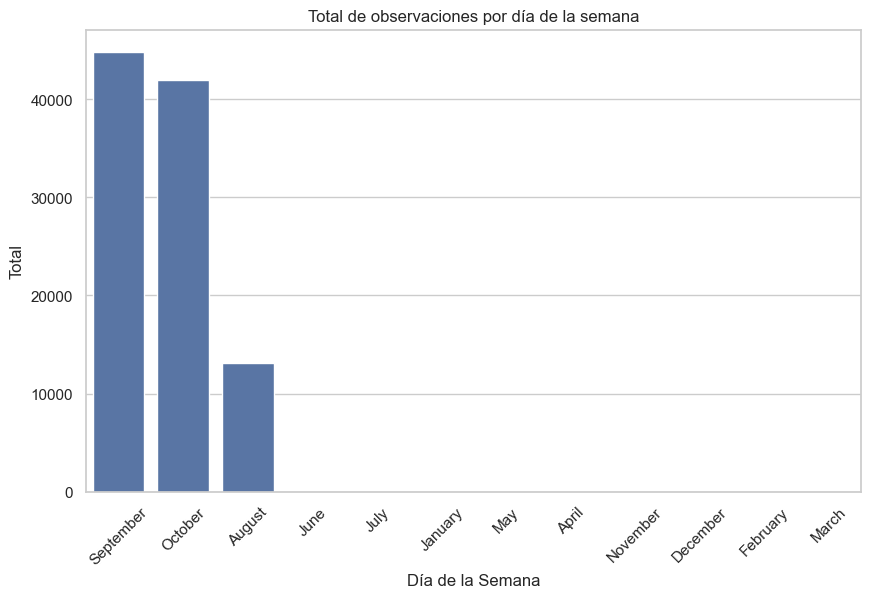

In [45]:
# Se grafica cómo se distribuyen las fechas en los días de la semana, para determinar si hay algún día en que no se registran.

week_day = df['last_updated'].apply(pd.to_datetime).dt.month_name()


day_counts = week_day.value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values)

plt.title('Total de observaciones por día de la semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Total')
plt.xticks(rotation=45)

plt.show()

En el gráfico se puede observar que las observaciones no están distribuidas uniformemente entre los días de la semana y mensualmente. Por lo tanto, se puede obtener valor utilizando estos features.

Para la codificación de la variable de fecha se piensa subdividir en año, mes, weekday y día.

In [46]:
df[['last_updated', 'date_created']] = df[['last_updated', 'date_created']].apply(pd.to_datetime)

df['date_created_year'] = df['date_created'].dt.year
df['date_created_month'] = df['date_created'].dt.month
df['date_created_weekday'] = df['date_created'].dt.weekday  # Número del día (0=lunes, 6=domingo)
df['date_created_day'] = df['date_created'].dt.day
df['last_updated_year'] = df['last_updated'].dt.year
df['last_updated_month'] = df['last_updated'].dt.month
df['last_updated_weekday'] = df['last_updated'].dt.weekday  # Número del día (0=lunes, 6=domingo)
df['last_updated_day'] = df['last_updated'].dt.day


df.drop(columns=['date_created', 'last_updated'], inplace=True)

##### Otras

In [47]:
others_col = []
for col in df.columns: 
    if col not in ID_VARS and '_updated' not in col and '_created' not in col and col not in VARIABLES_NUMERICAS:
        others_col.append(col)

In [48]:
print(others_col)

['warranty', 'sub_status', 'condition', 'attributes', 'buying_mode', 'tags', 'pictures', 'accepts_mercadopago', 'title', 'automatic_relist', 'status', 'seller_address.city.name', 'shipping.local_pick_up', 'shipping.free_shipping', 'shipping.mode', 'shipping.dimensions']


- Se va a analizar el contenido de las columnas restantes para eliminar en caso de ser necesario. Leugo se imputaran las restantes para completar el dataset.

In [49]:
df['flag_warranty'] = df['warranty'].apply(lambda x: 1 if isinstance(x, str) and ('si' in x.lower() or 'garant' in x.lower() or any(char.isdigit() for char in x)) else 0)
df['flag_usado'] = df['warranty'].apply(lambda x: 1 if isinstance(x, str) and ('uso' in x.lower() or 'usad' in x.lower()) else 0)
df.drop(columns=['warranty'], inplace=True)

In [50]:
df['pictures'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [51]:
df['title_len'] = df['title'].apply(lambda x: len(x)).value_counts().fillna(0)
df['title_used_flag'] = df['title'].apply(lambda x: 1 if isinstance(x, str) and ('uso' in x.lower() or 'usad' in x.lower()) else 0)
df.drop(columns=['title'], inplace=True)

In [52]:
print(df['shipping.dimensions'].notnull().sum())
df.drop(columns=['shipping.dimensions'], inplace=True)

23


# Limpieza y preparación de datos e ingeniería de features

## Tratamiento de outliers

En base a los diagramas de cajas de la sección anterior, no se observa la presencia de outliers multiples variables. A continuación se procede a tratar los outliers de las variables númericas mediante el análisis de los percentiles.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   sub_status                100000 non-null  object 
 1   condition                 100000 non-null  object 
 2   seller_id                 100000 non-null  int64  
 3   listing_type_id           100000 non-null  object 
 4   price                     100000 non-null  float64
 5   attributes                100000 non-null  int64  
 6   buying_mode               100000 non-null  object 
 7   tags                      100000 non-null  object 
 8   category_id               100000 non-null  int64  
 9   pictures                  100000 non-null  int64  
 10  official_store_id         818 non-null     float64
 11  accepts_mercadopago       100000 non-null  bool   
 12  currency_id               100000 non-null  object 
 13  automatic_relist          100000 non-null  bo

In [54]:
df.drop(columns=['catalog_product_id'], inplace=True)

In [55]:
df['official_store_id'] = df['official_store_id'].astype('Int64').fillna(0)

- variables a imputar:

In [56]:
VARIABLES_NUMERICAS = df.select_dtypes(include=['int64', 'Int64', 'int32', 'float64', 'bool']).columns.tolist()
VARIABLES_CATEGORICAS = df.select_dtypes(include=['object']).columns.tolist()

In [57]:
df[VARIABLES_NUMERICAS].describe()

,seller_id,price,attributes,category_id,pictures,official_store_id,stop_time,initial_quantity,start_time,sold_quantity,available_quantity,date_created_year,date_created_month,date_created_weekday,date_created_day,last_updated_year,last_updated_month,last_updated_weekday,last_updated_day,flag_warranty,flag_usado,title_len,title_used_flag
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.0,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,94.000000,100000.000000
mean,2.657370e+09,5.252433e+04,1.187550,39262.939290,2.931360,47.34893,1.447646e+12,35.093370,1.442383e+12,2.396990,34.842380,2014.998610,9.030420,2.57990,15.469630,2014.999950,9.287510,2.597050,14.440810,0.248670,0.007320,1063.829787,0.015350
std,3.280982e+09,8.623127e+06,7.543356,81196.936286,2.102825,574.13305,3.248586e+09,421.076196,2.114372e+09,42.685077,420.808403,0.039599,0.767776,1.94715,8.804068,0.007071,0.690096,1.904704,8.646896,0.432244,0.085244,1604.996162,0.122941
min,0.000000e+00,8.400000e-01,0.000000,0.000000,0.000000,0.0,1.444823e+12,1.000000,1.369110e+12,0.000000,1.000000,2013.000000,1.000000,0.00000,1.000000,2014.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000e+00,9.000000e+01,0.000000,1227.000000,1.000000,0.0,1.446312e+12,1.000000,1.441141e+12,0.000000,1.000000,2015.000000,9.000000,1.00000,8.000000,2015.000000,9.000000,1.000000,7.000000,0.000000,0.000000,5.250000,0.000000
50%,0.000000e+00,2.500000e+02,0.000000,7251.000000,2.000000,0.0,1.447640e+12,1.000000,1.442522e+12,0.000000,1.000000,2015.000000,9.000000,2.00000,15.000000,2015.000000,9.000000,2.000000,13.000000,0.000000,0.000000,326.500000,0.000000
75%,5.393436e+09,8.000000e+02,0.000000,41174.000000,4.000000,0.0,1.448931e+12,2.000000,1.443800e+12,0.000000,2.000000,2015.000000,10.000000,4.00000,23.000000,2015.000000,10.000000,4.000000,22.000000,0.000000,0.000000,1800.250000,0.000000
max,9.999582e+09,2.222222e+09,81.000000,377642.000000,36.000000,9996.0,1.730732e+12,9999.000000,1.444900e+12,8676.000000,9999.000000,2015.000000,12.000000,6.00000,31.000000,2015.000000,12.000000,6.000000,31.000000,1.000000,1.000000,10504.000000,1.000000


- no se observan nulos y solo se ven outliers en la variable price.

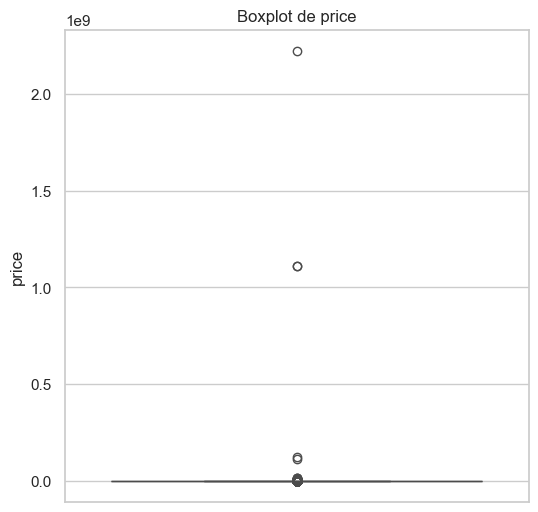

In [58]:
#boxplot de las variables numéricas
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, col in enumerate(['price']):
    row = i // ncols
    col_idx = i % ncols
    sns.boxplot(y=col, data=df , ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')
    axes[row, col_idx].set_ylabel(col)

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [59]:
Q1 = df['price'].quantile(0.25)  # Primer cuartil
Q3 = df['price'].quantile(0.75)  # Tercer cuartil
IQR = Q3 - Q1                    # Rango intercuartil

# Definir los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [60]:
df['price'] = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]['price']
df['price'].fillna(df['price'].max(), inplace=True)

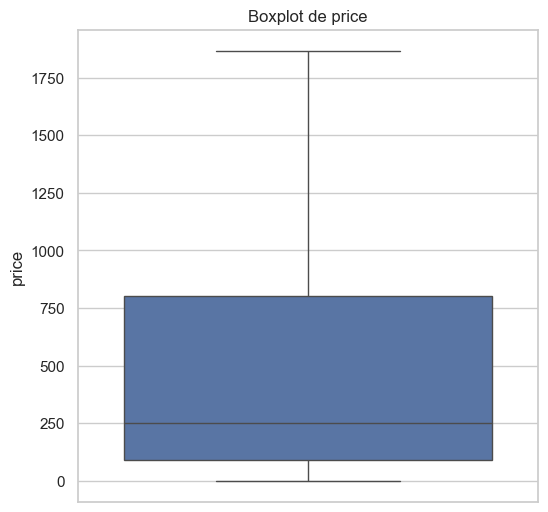

In [61]:
#boxplot de las variables numéricas
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, col in enumerate(['price']):
    row = i // ncols
    col_idx = i % ncols
    sns.boxplot(y=col, data=df , ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot de {col}')
    axes[row, col_idx].set_ylabel(col)

for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

- escalamiento de campos numericos

stop_time, start_time, date_created_year, date_created_month, date_created_weekday, date_created_day, last_updated_year, last_updated_month, last_updated_weekday, last_updated_day

In [62]:
fields_to_scale = ['stop_time', 'start_time', 'date_created_year', 'date_created_month','date_created_weekday', 
                   'date_created_day', 'last_updated_year', 'last_updated_month', 'last_updated_weekday', 'last_updated_day']

In [63]:
scaler = MinMaxScaler()
df[fields_to_scale] = scaler.fit_transform(df[fields_to_scale])

## Tratamiento de datos faltantes y Codificación de variables categóricas

A continuación se procede a realizar el tratamiento de los datos faltantes en el dataset. Realizando una imputación de los datos faltantes en función de la naturaleza de las variables, en caso de ser necesario.

### Análisis de datos faltantes

<Axes: >

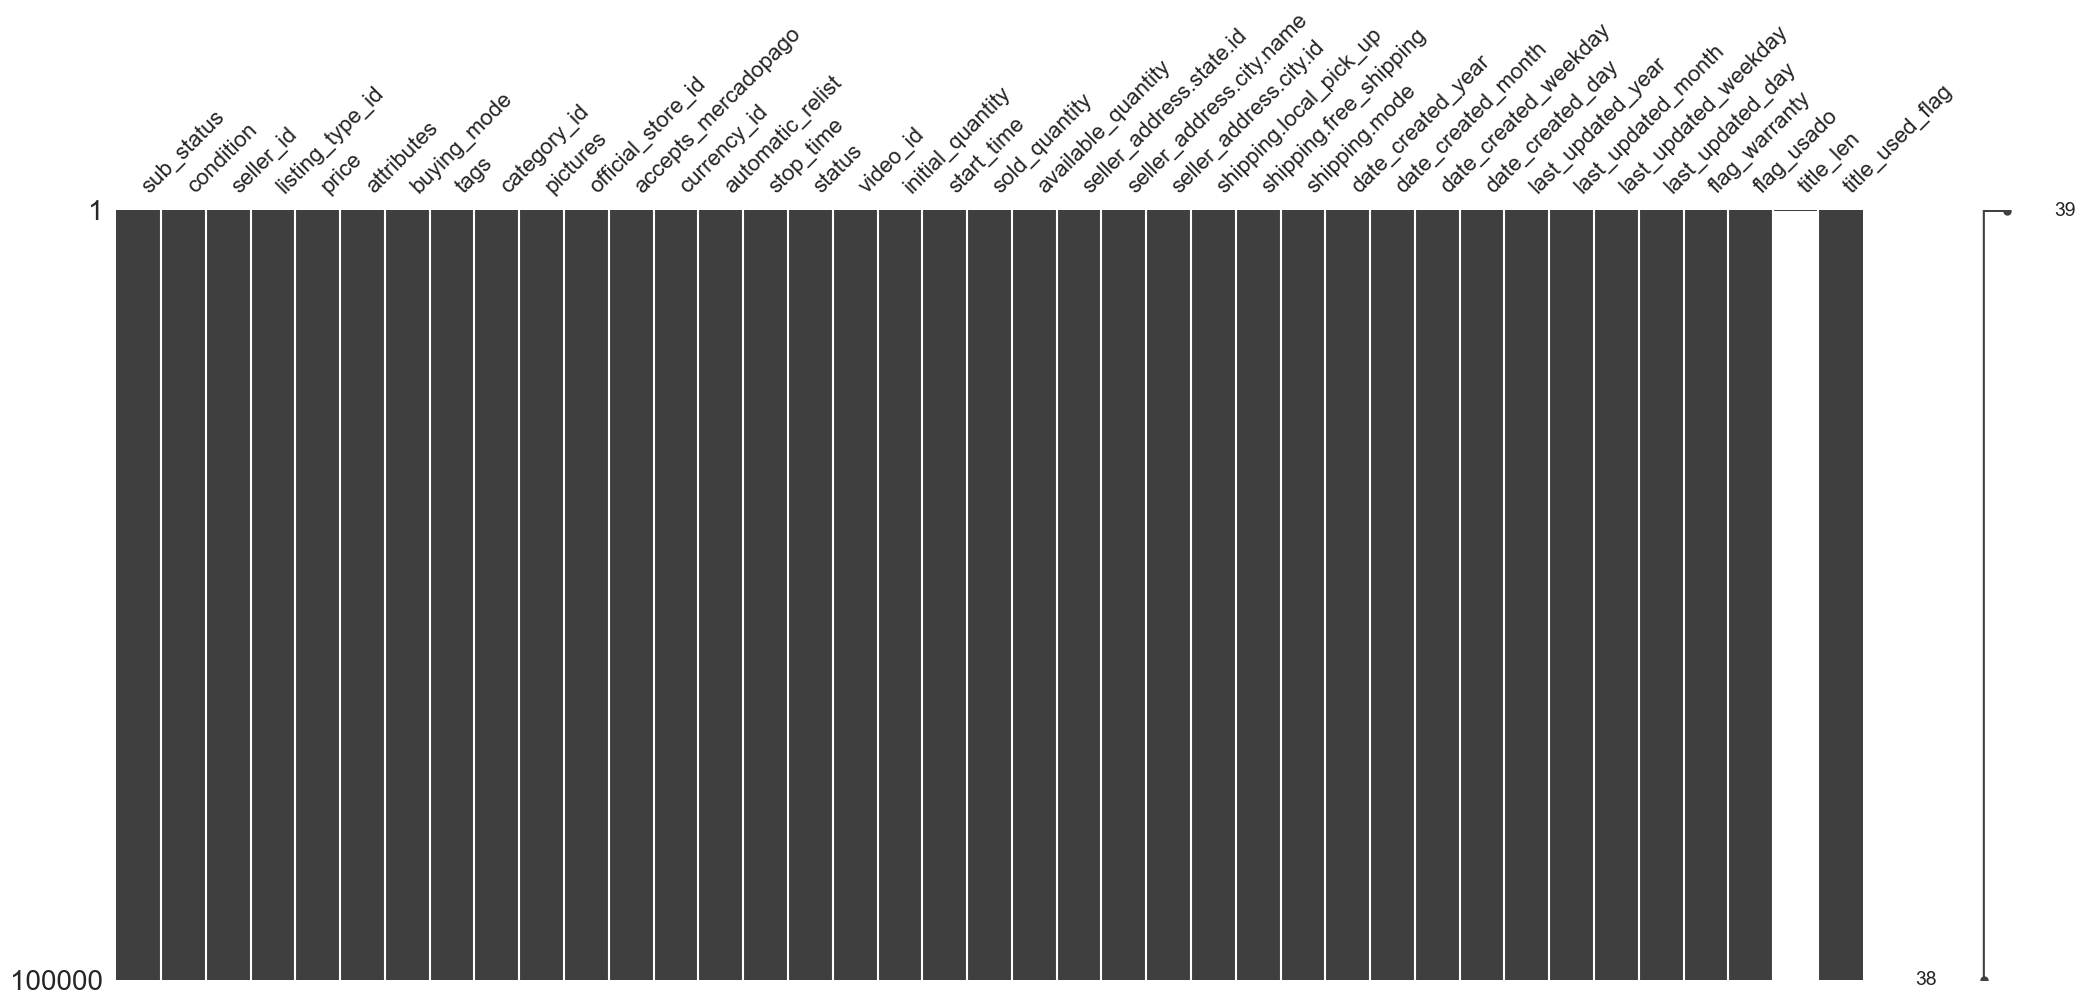

In [64]:
# relacion entre los datos faltantes de las columnas
msno.matrix(df)

Se puede observar que el dataset no contiene registros duplicados y no hay datos faltantes en el target.

La lógica de algunas columnas debe cumplir condiciones específicas. Por ejemplo: df['available_quantity'] - df['sold_quantity'] = df['initial_quantity']

In [65]:
def check_available_sold_condition(df):
    condition = (df['available_quantity'] + df['sold_quantity']) == df['initial_quantity']
    count_true = condition.sum()
    count_false = len(df) - count_true
    return count_true, count_false

count_true, count_false = check_available_sold_condition(df)
print("Número de filas que satisfacen la condición:", count_true)
print("Número de filas que no satisfacen la condición:", count_false)


Número de filas que satisfacen la condición: 84675
Número de filas que no satisfacen la condición: 15325


In [66]:
condition = (df['available_quantity'] + df['sold_quantity']) == df['initial_quantity']
print(df[~condition][["initial_quantity","sold_quantity", "available_quantity"]])
print(df[~condition]["sold_quantity"].value_counts())

       initial_quantity  sold_quantity  available_quantity
11                    1              1                   1
12                    1              1                   1
15                    1              4                   1
19                    1              1                   1
29                    4              2                   4
...                 ...            ...                 ...
99975                 1              1                   1
99980                 9              1                   9
99981               945              3                 945
99985                 8              5                   8
99989                 1              1                   1

[15325 rows x 3 columns]
sold_quantity
1       5675
2       2247
3       1238
4        889
5        626
        ... 
178        1
483        1
8676       1
348        1
578        1
Name: count, Length: 313, dtype: int64


Vemos que no todos los casos cumplen la condición, si el modelo llega a utilizar en gran medida estas columnas, se puede considerar eliminarlas.

### Códificación de variables categóricas

#### Codificacion target

In [67]:
df[VARIABLE_SALIDA] = df[VARIABLE_SALIDA].map({'new': 0, 'used': 1})

#### Codificacion One Hot

In [68]:
one_hot_features

['listing_type_id', 'currency_id']

In [69]:
df['currency_id'] = df['currency_id'].map({'ARS': 0, 'USD': 1})

In [70]:
df = pd.get_dummies(df, columns=['listing_type_id'], prefix='type', drop_first=True)

#### Codificacion LabelEncoder

In [71]:
print(label_features)
# se agregan los features categoricos obtenidos por la expansion de los campos json
columns_to_labelEncode = ['sub_status', 'buying_mode', 'tags', 'status', 'video_id', 
    'seller_address.state.id', 'seller_address.city.name', 
    'seller_address.city.id', 'shipping.mode', 'category_id', 'seller_id']
for col in columns_to_labelEncode:
    label_features.append(col)
print(label_features)

['video_id', 'seller_address.state.id', 'seller_address.city.id']
['video_id', 'seller_address.state.id', 'seller_address.city.id', 'sub_status', 'buying_mode', 'tags', 'status', 'video_id', 'seller_address.state.id', 'seller_address.city.name', 'seller_address.city.id', 'shipping.mode', 'category_id', 'seller_id']


In [72]:
label_encoders = {}
for col in label_features:
    le = LabelEncoder()
    # Ajustar y transformar la columna
    df[col] = le.fit_transform(df[col].astype(str))  # Convertir a string si hay datos no numéricos
    # Guardar el codificador para posibles usos futuros
    label_encoders[col] = le

In [73]:
df = df.fillna(0)
df

,sub_status,condition,seller_id,price,attributes,buying_mode,tags,category_id,pictures,official_store_id,accepts_mercadopago,currency_id,automatic_relist,stop_time,status,video_id,initial_quantity,start_time,sold_quantity,available_quantity,seller_address.state.id,seller_address.city.name,seller_address.city.id,shipping.local_pick_up,shipping.free_shipping,shipping.mode,date_created_year,date_created_month,date_created_weekday,date_created_day,last_updated_year,last_updated_month,last_updated_weekday,last_updated_day,flag_warranty,flag_usado,title_len,title_used_flag,type_free,type_gold,type_gold_premium,type_gold_pro,type_gold_special,type_silver
0,3,0,0,80.0,0,1,0,0,2,0,True,0,False,0.006458,0,16,1,0.954945,0,1,18,2044,192,True,False,3,1.0,0.727273,0.833333,0.133333,1.0,0.727273,0.833333,0.133333,0,0,0.0,0,False,False,False,False,False,False
1,3,1,0,1865.0,0,1,7,29,6,0,True,0,False,0.012771,0,16,1,0.978763,0,1,18,381,0,True,False,2,1.0,0.727273,0.833333,0.833333,1.0,0.727273,0.833333,0.833333,0,0,1.0,0,False,False,False,False,False,True
2,3,1,1658,60.0,0,1,0,204,1,0,True,0,False,0.007707,0,16,1,0.959659,0,1,18,345,160,True,False,2,1.0,0.727273,0.333333,0.266667,1.0,0.727273,0.333333,0.266667,0,0,0.0,0,False,False,False,False,False,False
3,3,0,0,580.0,0,1,7,1895,2,0,True,0,False,0.015278,0,16,1,0.981074,0,1,18,947,169,True,False,2,1.0,0.727273,0.000000,0.900000,1.0,0.818182,0.000000,0.133333,0,0,6.0,0,False,False,False,False,False,True
4,3,1,433,30.0,0,1,0,1228,2,0,True,0,False,0.002849,0,16,1,0.941332,0,1,12,2262,129,True,False,3,1.0,0.636364,0.000000,0.766667,1.0,0.636364,0.666667,0.900000,0,0,23.0,0,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,1,99,30.0,0,1,0,1228,6,0,True,0,False,0.013161,0,16,1,0.980233,0,1,12,836,0,True,False,2,1.0,0.727273,0.000000,0.900000,1.0,0.727273,0.000000,0.900000,0,0,0.0,0,True,False,False,False,False,False
99996,3,0,0,239.0,0,1,7,338,3,0,True,0,False,0.008238,0,16,5,0.961664,0,5,12,1381,53,False,False,3,1.0,0.727273,0.666667,0.333333,1.0,0.727273,0.666667,0.333333,0,0,0.0,0,False,False,False,False,False,False
99997,3,1,0,600.0,2,1,7,488,1,0,True,0,False,0.006782,0,16,1,0.956170,0,1,12,1582,201,False,False,2,1.0,0.727273,1.000000,0.166667,1.0,0.727273,1.000000,0.166667,0,0,0.0,0,False,False,False,False,False,False
99998,3,1,1242,50.0,0,1,0,786,1,0,True,0,False,0.000976,0,16,1,0.934267,0,1,18,241,152,True,False,2,1.0,0.636364,0.166667,0.566667,1.0,0.636364,0.166667,0.566667,0,0,0.0,0,False,False,False,False,False,False


## Análisis de relaciones entre variables y selección de variables más importantes

Para ver la importancia que van a tener estas variables en los modelos, proponemos un feature selector basado en árboles de desición utilizando la librería XGBoost y Sklearn. 

Para este "modelo" selector vamos a trabajar con una muestra mucho más acotada que un set de entrenamiento convencional para un modelo productivo.

### Técnica 1

In [74]:
df_sample = df.sample(n=10000)
#df_sample.dropna(how='any',inplace=True)
df_sample.shape

(10000, 44)

Vemos que el dropna(how='any') no elimina ninguna fila, por ende los registros se encuentran imputados sin prescencia de nulos.

In [75]:
model_target = VARIABLE_SALIDA
y = df_sample[model_target]
X = df_sample.drop(columns = model_target)

In [76]:
# Crear DMatrix
from xgboost import DMatrix

X = df.drop([model_target], axis=1)
y = df[model_target]

dtrain = DMatrix(X, label=y, enable_categorical=True)

# Entrenar XGBClassifier
selector = SelectFromModel(estimator=xgb.XGBClassifier(), max_features=28)
selector.fit(X, y)
relevant_features = list(selector.get_feature_names_out())

In [77]:
# primer arbol selector de 50 features importantes de un total de 76
selector = SelectFromModel(estimator=xgb.XGBClassifier(),max_features=28)
selector.fit(X, y)
relevant_features = list(selector.get_feature_names_out())

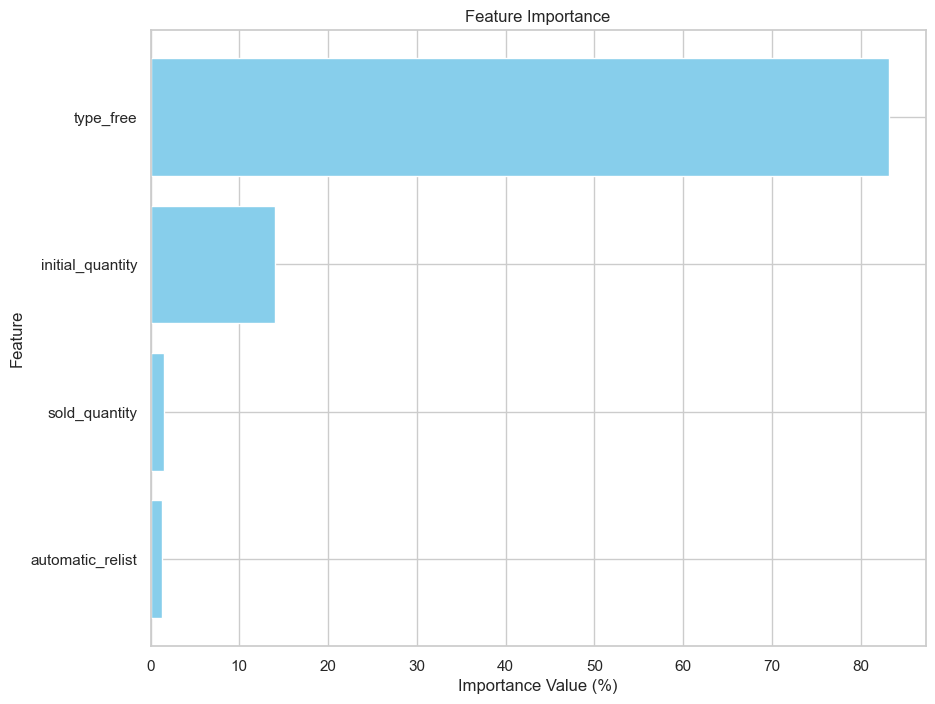

In [78]:
# estimador de feature importance
estimator = xgb.XGBClassifier()
estimator.fit(X[relevant_features], y)
feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importances_,X[relevant_features].columns)), columns=['Value','Feature'])

#feature_imp.sort_values(by="Value", ascending=False)

# gráfico de barras horizontales
plt.figure(figsize=(10, 8)) 
plt.barh(feature_imp['Feature'], feature_imp['Value']*100, color='skyblue')  

# Añadir etiquetas y título
plt.xlabel('Importance Value (%)')  
plt.ylabel('Feature')         
plt.title('Feature Importance')

# Mostrar el gráfico
plt.show()

Se puede observar una aproximación a las features mas improtantes que va a usar un modelo, en especial si modelamos una clasificación mediante un arbol desición.

### Técnica 2

Visualizando la distribuciones generadas por cada feature en funcion del target. El objetivo es ver si algun feature logra discriminar en gran medida al target.

Vamos a imprimir los feature en grupos de 15 features.

['sub_status', 'condition', 'seller_id', 'price', 'attributes', 'buying_mode', 'tags', 'category_id', 'pictures', 'official_store_id', 'accepts_mercadopago', 'currency_id', 'automatic_relist', 'stop_time', 'status', 'video_id', 'initial_quantity', 'start_time', 'sold_quantity', 'available_quantity', 'seller_address.state.id', 'seller_address.city.name', 'seller_address.city.id', 'shipping.local_pick_up', 'shipping.free_shipping', 'shipping.mode', 'date_created_year', 'date_created_month', 'date_created_weekday', 'date_created_day', 'last_updated_year', 'last_updated_month', 'last_updated_weekday', 'last_updated_day', 'flag_warranty', 'flag_usado', 'title_len', 'title_used_flag', 'type_free', 'type_gold', 'type_gold_premium', 'type_gold_pro', 'type_gold_special', 'type_silver']


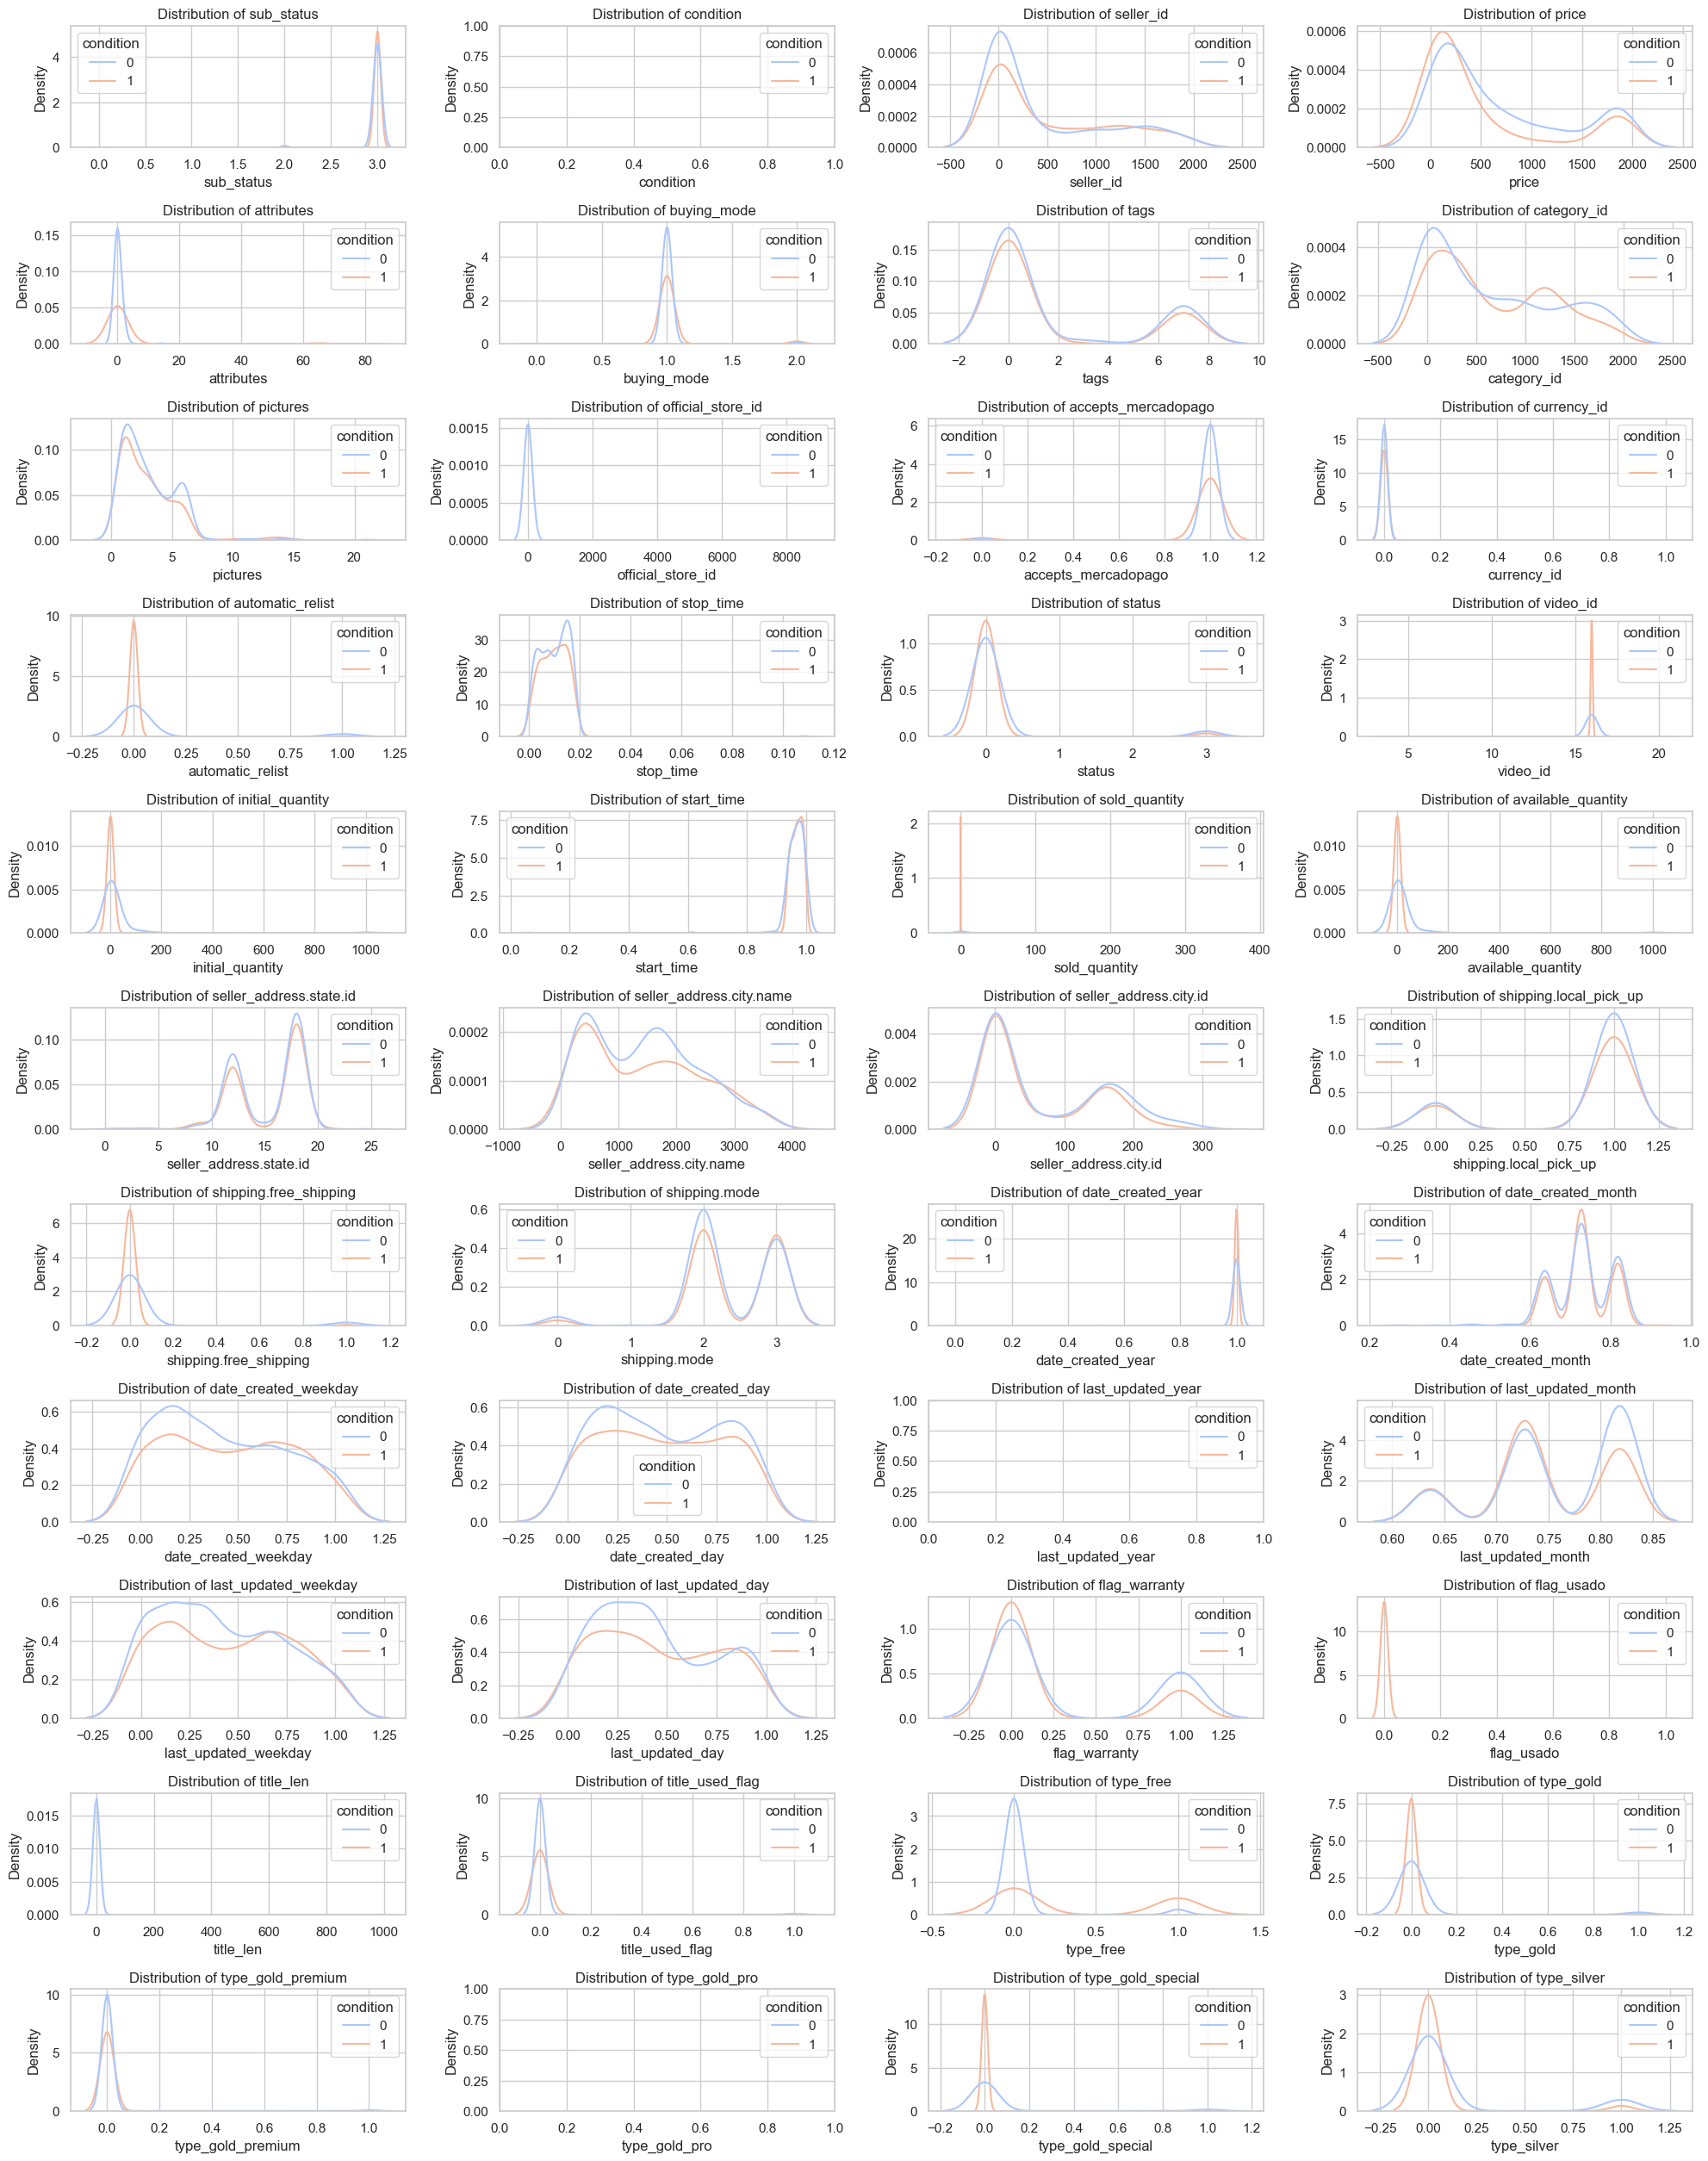

In [79]:
# Sample the data
sampled_data = df.sample(1000)

# Define the variables of interest
variables_of_interest = df.columns.to_list()
print(variables_of_interest)
# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(44, 4, figsize=(20, 100))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the list of variables and corresponding axes
for ax, var in zip(axes, variables_of_interest):
    sns.kdeplot(data=sampled_data, x=var, hue='condition', palette='coolwarm', ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {var}')

# Remove any unused axes
for ax in axes[len(variables_of_interest):]:
    fig.delaxes(ax)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


A partir del análisis de las distribuciones de las variables en función del target, se puede observar diferentes comportamientos. Algunas variables presentan distribuciones muy similares entre las clases, mientras que otras presentan diferencias notables.
En el caso de type_free, la variable mas usada en el arbol de desicion, podemos ver que permite separar casi todo el universo de los productos nuevos (0) perdiendo solamente la mitad de los usados (1). Otras variables muestran la alta densidad que poseen los usados para dicho campo.

Sin embargo, no se identifica una variable unica que permita tomar la desicion, por lo que se va a recurrir al desarrollo de un modelo.

# Export de dataset

## Dataset auxiliares

- payment methods

In [80]:
df_methods = pd.read_csv('dataset/extra/payment_methods.csv')
max_methods = 3
col_1 = 'non_mercado_pago_payment_methods.id'
col_2 = 'non_mercado_pago_payment_methods.type'

In [81]:
df_methods = df_methods.groupby('index').agg({
    col_1: list,
    col_2: list
}).reset_index()

for i in range(max_methods):
    df_methods[f'method_{i+1}'] = df_methods[col_1].apply(
        lambda x: x[i] if i < len(x) else None
    )
    df_methods[f'type_{i+1}'] = df_methods[col_2].apply(
        lambda x: x[i] if i < len(x) else None
    )

# Agregar el flag 'other' si hay más de 3 métodos
df_methods['other'] = df_methods[col_1].apply(
    lambda x: len(x) > max_methods
)

df_payment_methods = df_methods.drop(columns=[col_1, col_2])
df_payment_methods #.set_index('index')

,index,method_1,type_1,method_2,type_2,method_3,type_3,other
0,0,MLATB,G,MLAWC,G,MLAMO,G,False
1,1,MLATB,G,MLAMO,G,None,None,False
2,2,MLATB,G,MLAOT,N,MLAMO,G,False
3,3,MLATB,G,MLAOT,N,MLAMO,G,False
4,4,MLATB,G,MLAWC,G,MLAMO,G,False
...,...,...,...,...,...,...,...,...
69436,99994,MLAOT,N,MLAMO,G,None,None,False
69437,99995,MLATB,G,MLAMO,G,None,None,False
69438,99996,MLAOT,N,MLAMO,G,None,None,False
69439,99998,MLATB,G,MLAMO,G,None,None,False


In [82]:
# Lista de columnas a procesar
columns_to_encode = ['method_1', 'method_2', 'method_3', 'type_1', 'type_2', 'type_3']

for col in columns_to_encode:
    le = LabelEncoder()
    le.fit(list(df_payment_methods[col].unique()))
    df_payment_methods[col] = le.transform(df_payment_methods[col])
    label_encoders[col] = le


- shipping free methods

In [83]:
df_methods = pd.read_csv('dataset/extra/shipping_free_methods.csv')
max_methods = 1
col_1 = 'shipping.free_methods.id'

In [84]:
df_methods = df_methods.groupby('index').agg({
    col_1: list,
}).reset_index()

for i in range(max_methods):
    df_methods[f'method_{i+1}'] = df_methods[col_1].apply(
        lambda x: x[i] if i < len(x) else None
    ).astype(int)

df_ship_methods = df_methods.drop(columns=[col_1])

In [85]:
df_ship_methods.value_counts()

index  method_1
99980  73328       1
8      73328       1
42     73328       1
58     73328       1
65     73328       1
                  ..
438    73328       1
413    73328       1
400    73328       1
398    73328       1
346    73328       1
Name: count, Length: 3006, dtype: int64

In [86]:
# reemplazamos pro un flag
df_ship_methods['df_ship_methods'] = True
df_ship_methods.drop(columns=['method_1'])

,index,df_ship_methods
0,8,True
1,42,True
2,58,True
3,65,True
4,128,True
...,...,...
3001,99825,True
3002,99837,True
3003,99887,True
3004,99952,True


- variations

In [87]:
df_methods = pd.read_csv('dataset/extra/variations.csv')

In [88]:
# Me interesa ver si tiene mas de una variacion
variations = df_methods.groupby('index').agg(
    appearances=('index', 'count'),
    sold_quantity=('variations.sold_quantity', 'nunique')
).reset_index()

## Dataset Final

In [89]:
merged_df = df.merge(df_payment_methods, left_index=True, right_on='index', how='left')

In [90]:
merged_df = merged_df.merge(df_ship_methods, left_on='index', right_on='index', how='left')

In [91]:
merged_df = merged_df.merge(variations, left_on='index', right_on='index', how='left')

In [92]:
merged_df.iloc[:, -11:] = merged_df.iloc[:, -11:].fillna(0)

In [93]:
merged_df.to_csv('dataset/data_final.csv')

- Se va a trabanar con el dataset final en otro notebook.